In [1]:
import os
import warnings

import math
import pycbc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

warnings.filterwarnings('ignore')

/home/ashishthomas.mathew/.conda/envs/gengli_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
from modules import statistical_testing

In [3]:
glitches = pd.read_csv('./glitches/O3a_allifo.csv', usecols=['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'])
glitches = glitches[~glitches.duplicated(subset=['GPStime'], keep='first')]
glitches = glitches[glitches["ifo"] == "L1"]

glitches.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'], dtype='object')

# Testing our normality tests on a combined dataset of glitches and clean data

In this case we have a rather unique challenge where the data at hand is fairly unbalanced, with variations in the number of glitches and clean samples. Hence, for this case I'll take around 1000 samples of each to see how things go.

Our data with glitches has a lot more information to work with such as snr, duration and confidence, which we will not be taking into consideration for now since we want to look at what is common betwen clean and glitches samples.

Additionally our glitches are marked by particular GPS times around which we need to consider a time window to whiten and crop the sample into workable segments for our statistical tests. Our clean data is in the form of time segments of relative "silence" which we will have to process as is and divide into equally sized segments as our glitch data. 

## Loading the data

Let's generate this dataset below

In [4]:
glitch_count_df = glitches["label"].value_counts().rename_axis('Glitch Class').reset_index(name='Count')
glitch_count_df.to_latex("./outputs/glitch_counts.tex", index=False, float_format="%.0f", escape=False)

In [5]:
selection = glitches[(glitches['label'] == 'Tomte')]
samples = statistical_testing.fetch_glitch_data_from_csv(selection, begin=0, n_samples=10)

<class 'int'> <class 'int'> <class 'int'>
Time elapsed for q-transform: 0.15 seconds


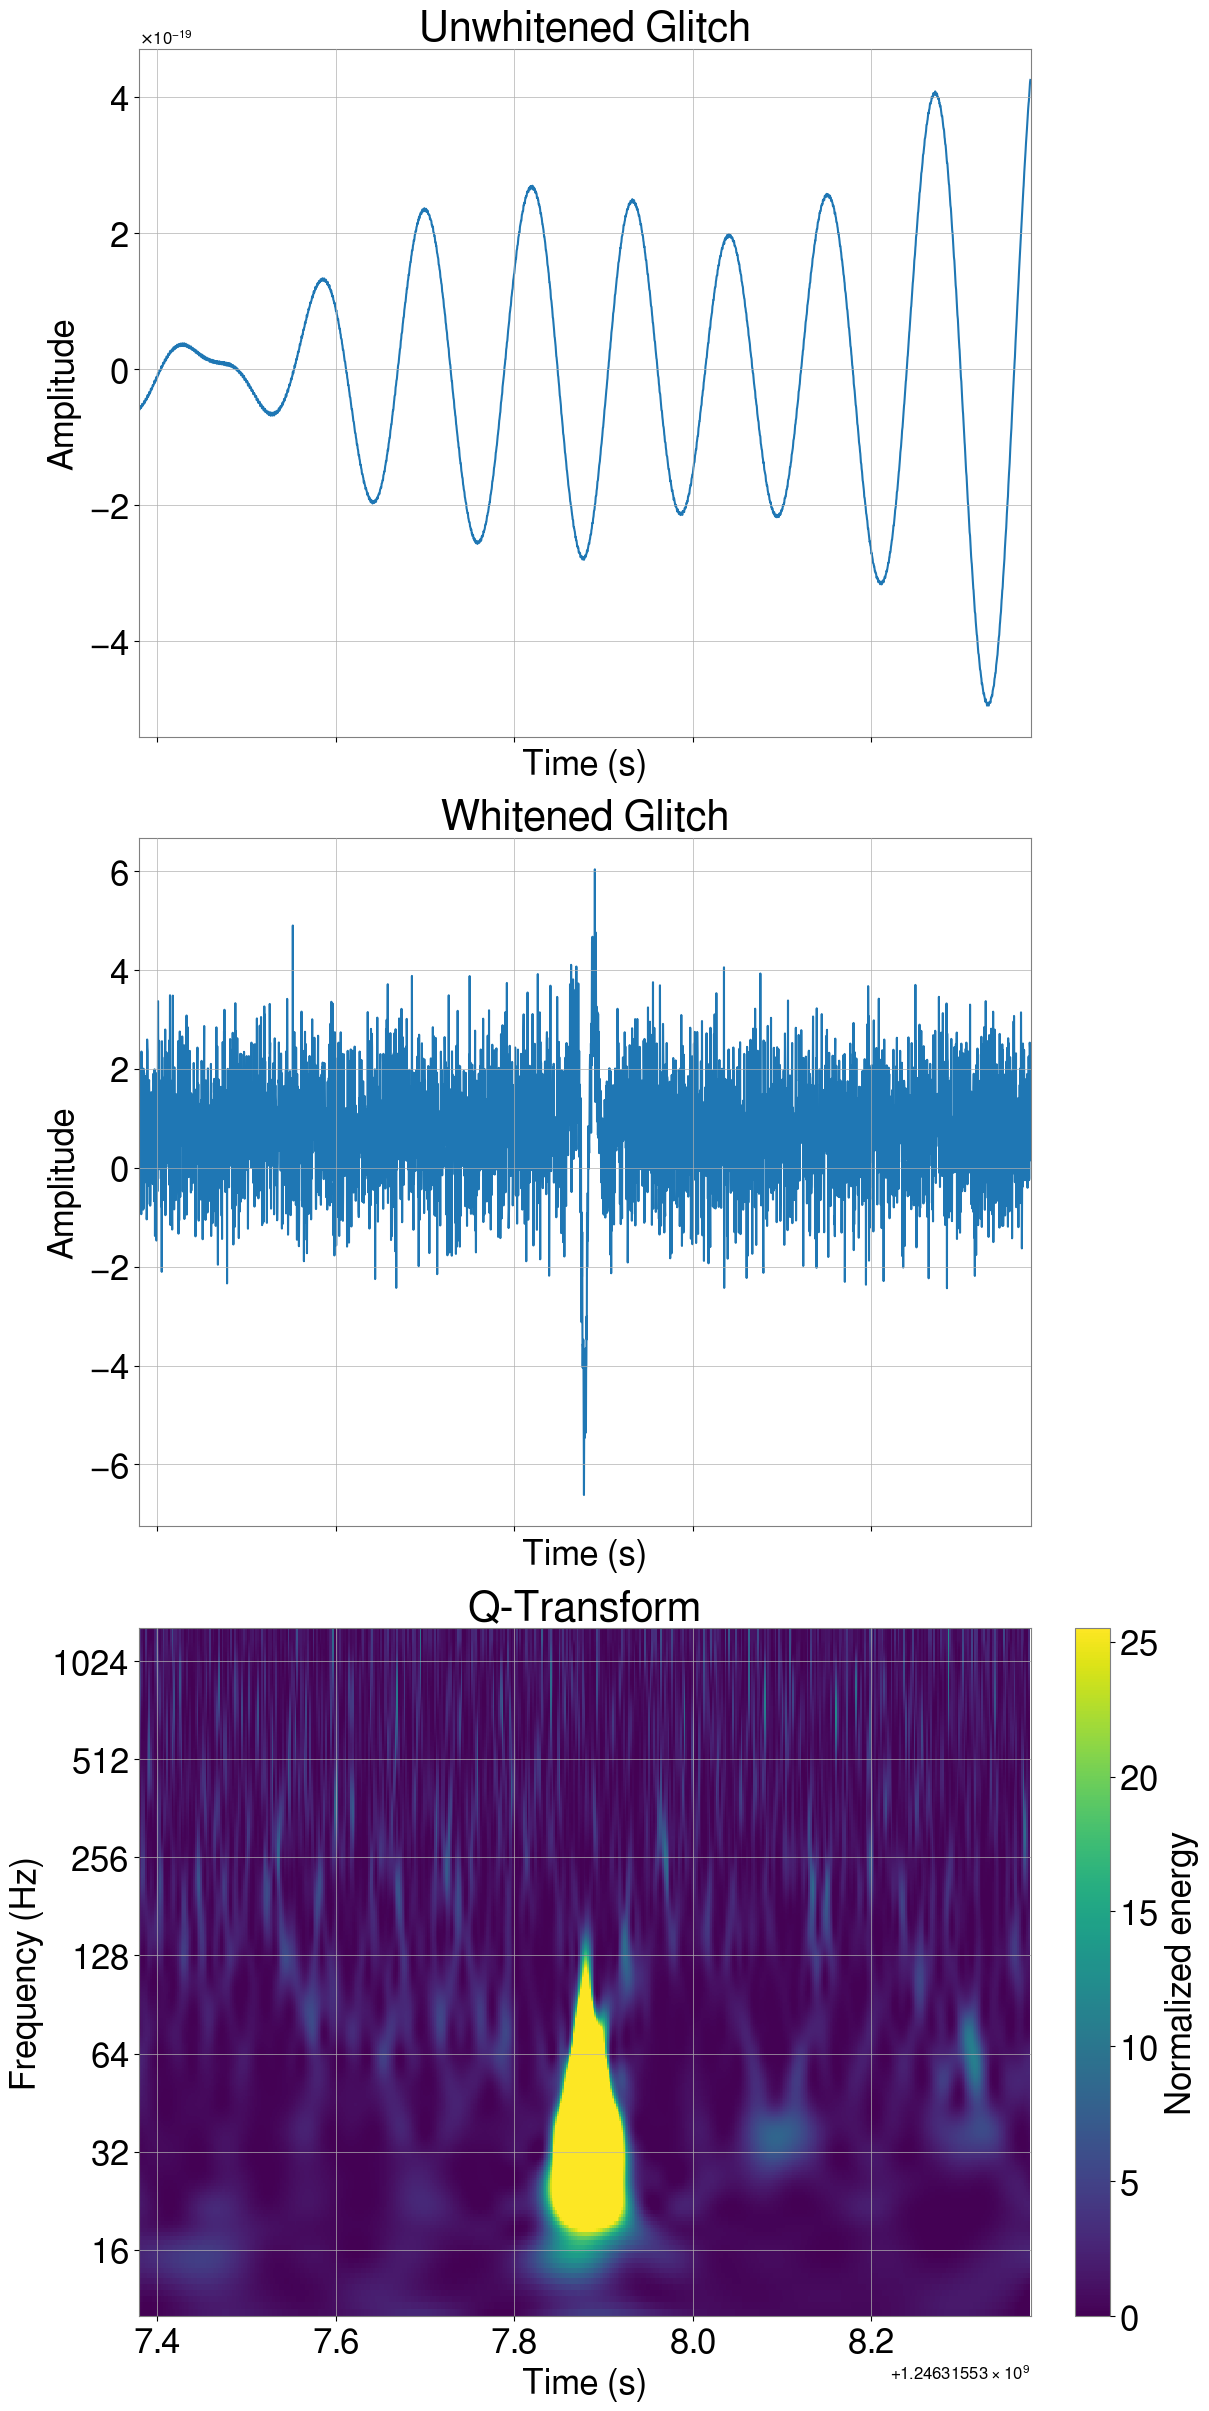

In [6]:
statistical_testing.display_sample_plots(samples.iloc[9], save_path="./outputs/sample_plot.pdf")

In [7]:
samples.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label',
       'unwhitened_y', 'whitened_y', 't', 'timeseries_file_location',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'glitch_present'],
      dtype='object')

In [8]:
sample_timeseries = TimeSeries.read(samples["timeseries_file_location"].iloc[0])

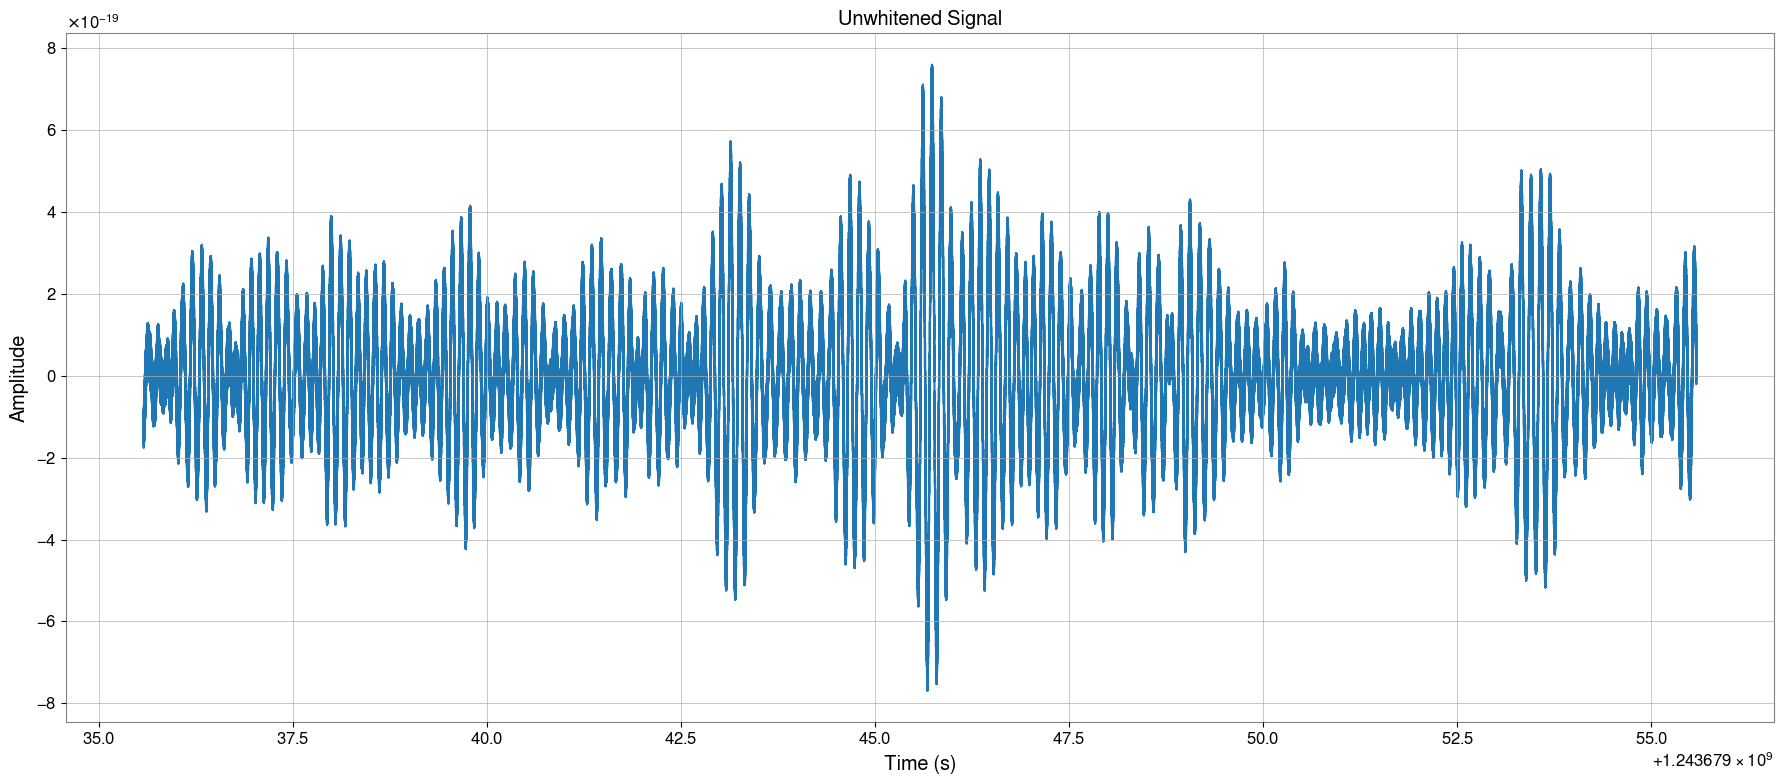

In [9]:
# plot the unwhitened y values for the first chirp
fig = plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries.times, sample_timeseries.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Unwhitened Signal")
plt.tight_layout()
plt.savefig("./outputs/unwhitened_signal.pdf", dpi=100)

In [10]:
#whiten the timeseries
sample_timeseries_whitened = sample_timeseries.whiten(4,2)

In [11]:
sample_timeseries_whitened = sample_timeseries_whitened[int(4096*4):-int(4096*4)]

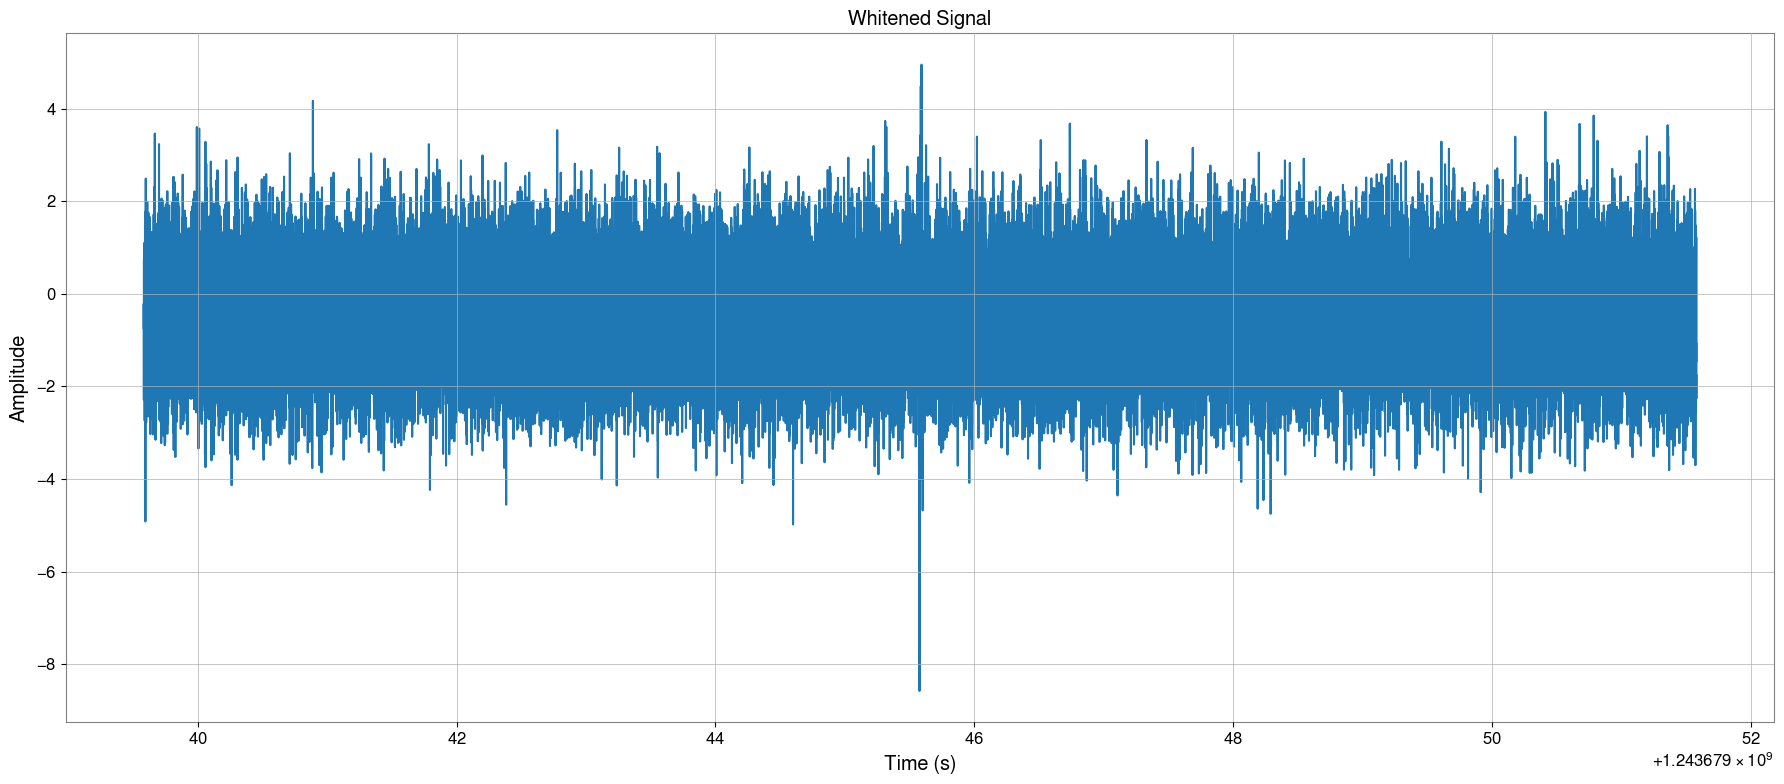

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries_whitened.times, sample_timeseries_whitened.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Whitened Signal")
plt.tight_layout()
plt.savefig("./outputs/whitened_signal.pdf", dpi=100)

In [13]:
sample_asd = sample_timeseries.asd(4, 2)

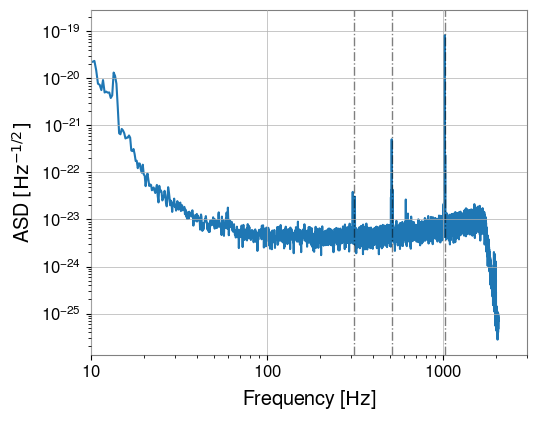

In [14]:
plot = sample_asd.plot()
ax = plot.gca()
ax.set_xlim(10, 3000)
# ax.set_ylim(5e-26, 1e-21)

#plot dotted lines at 512 Hz and 1024Hz
ax.axvline(x=310, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=510, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=1020, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.set_ylabel("ASD $[\mathrm{Hz}^{-1/2}]$")

plot.savefig("./outputs/unwhitened_asd.pdf", dpi=100)

In [15]:
labels = ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip',
       'Blip_Low_Frequency', 'Chirp', 'Extremely_Loud',
       'Fast_Scattering', 'Helix', 'Koi_Fish',
       'Light_Modulation', 'Low_Frequency_Burst',
       'Low_Frequency_Lines', 'Paired_Doves',
       'Power_Line', 'Repeating_Blips', 'Scattered_Light',
       'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle', 'clean_signal']

columns = ['Label', "TP", "FN","FP", "TN", "Accuracy", "Recall(TPR/Sensitivity)", "Specificity", "FPR", "FNR", "Precision", "F1 Score"]


def generate_glitchwise_confusion_matrices(df, test="Shapiro"):

    scaler = StandardScaler()

    confusion_matrix_df = pd.DataFrame(columns=columns)
    for label in labels:
        temp_df = df[df['label'] == label]

        # print(f"Loading {label} data...")

        # temp_df = statistical_testing.fetch_glitch_data_from_csv(temp_df, tw=10, bandpass=bandpass, low_freq=low_feq, high_freq=high_freq)
        # temp_df.dropna(inplace=True)

        # print(f"Generating confusion matrix for {label}...")
        if test == "Shapiro":
            cm = statistical_testing.generate_confusion_matrix(temp_df)
        elif test == "KS":
            cm = statistical_testing.generate_confusion_matrix(temp_df, "KS")
        elif test == "Anderson":
            cm = statistical_testing.generate_confusion_matrix(temp_df, "Anderson")

        metrics = list(statistical_testing.generate_evaluation_metrics(cm))

        cm = cm.flatten()

        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[label] + cm.tolist() + metrics], columns=columns)], ignore_index=True)

    return confusion_matrix_df
    

In [16]:
def generate_testwise_confusion_matrix(df):

    confusion_matrix_df = pd.DataFrame(columns=["Test","TP","FN","FP","TN", "Accuracy", "Recall(TPR/Sensitivity)", "Specificity", "FPR", "FNR","Precision","F1 Score"])
    for test in ["Shapiro", "KS", "Anderson"]:
        # print(f"Generating confusion matrix for {test}...")
        cm = statistical_testing.generate_confusion_matrix(df, test)
        metrics = list(statistical_testing.generate_evaluation_metrics(cm))
        cm = cm.flatten()
        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[test] + cm.tolist() + metrics], columns=confusion_matrix_df.columns)], ignore_index=True)
    
    return confusion_matrix_df

In [17]:
# Loading up the clean segments
clean_gpstimes = pd.read_csv("./clean_segments/pre_clean_segments_O3a_L1.csv", usecols=['start_time', 'end_time', 'p_values'])

# Loading up the glitch data times and randomly sampling 51 glitches from each label
sample_glitches = pd.read_csv('./glitches/DQ_glitches_O3a.csv', usecols=['GPStime', 'ifo', 'label','snr'])
# Excluide 'no_glitch' label
sample_glitches = sample_glitches[sample_glitches['label'] != 'No_Glitch']
sample_glitches = sample_glitches[~sample_glitches.duplicated(subset=['GPStime'], keep='first')]


if not os.path.isfile("./glitches/random_samples.csv"):
    sample_glitches_df = sample_glitches[sample_glitches['ifo'] == 'L1'].groupby('label').apply(lambda x: x.sample(n=min(len(x),101))).reset_index(drop=True)
    sample_glitches_df.to_csv("./glitches/random_samples.csv", index=False)
else:
    sample_glitches_df = pd.read_csv("./glitches/random_samples.csv", index_col=False)

In [18]:
sample_glitches_df.shape

(1831, 4)

In [19]:
sample_glitches_df.head()

GPStime      snr ifo      label
0 1243645823.14600 10.26000  L1  1080Lines
1 1243586559.13700 11.94400  L1  1080Lines
2 1248843684.68100  8.48800  L1  1080Lines
3 1246314144.06300 12.84000  L1  1080Lines
4 1252075134.94000  9.38500  L1  1080Lines

In [20]:
def create_combined_glitch_clean_df(clean_gpstimes, sample_glitches_df, n_samples=1000, whitening_tw: int=10, observation_tw: float = 1, segment_duration_seconds: float=1, bandpass=False, low_freq=10, high_freq=250):
    clean_samples_df = statistical_testing.fetch_clean_segment_samples(clean_gpstimes, n_samples=n_samples, segment_duration_seconds=segment_duration_seconds, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)
    sample_glitches_df = statistical_testing.fetch_glitch_data_from_csv(sample_glitches_df, whitening_tw=whitening_tw, observation_tw=observation_tw, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)

    print(clean_samples_df.columns)
    print(sample_glitches_df.columns)
    # , 'shapiro_prediction', 'ks_prediction', 'ad_prediction'
    sample_glitches_df = sample_glitches_df[['whitened_y', 'unwhitened_y', 't', "timeseries_file_location", 'shapiro_statistic', 'shapiro_pvalue',
	    'ks_statistic', 'ks_pvalue', 'ad_statistic',
	    'ad_critical_values', 'ad_significance_level', 'kurtosis', 'skew',
	    'ifo', 'label', 'glitch_present', 'snr']]

    sample_glitches_df = sample_glitches_df.dropna()
    clean_samples_df = clean_samples_df.dropna()

    # Combining the clean and glitch data
    combined_df = pd.concat([clean_samples_df, sample_glitches_df], ignore_index=True)
    
    return combined_df

In [21]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [22]:
combined_df[combined_df.isna().any(axis=1)].head()

Empty DataFrame
Columns: [whitened_y, t, timeseries_file_location, unwhitened_y, shapiro_statistic, shapiro_pvalue, ks_statistic, ks_pvalue, ad_statistic, ad_critical_values, ad_significance_level, kurtosis, skew, ifo, label, glitch_present, snr]
Index: []

In [23]:
len(combined_df)

3593

In [24]:
len(combined_df[combined_df["glitch_present"]== 1])


1769

In [25]:
len(combined_df[combined_df["glitch_present"]== 0])

1824

In [26]:
combined_df["label"].value_counts().to_latex("./outputs/combined_glitch_clean_counts.tex", index=True, float_format="%.0f", escape=False)

In [27]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'], save_img=True)

In [28]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS", save_img=True)

In [29]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson", save_img=True)

In [30]:
statistical_testing.display_confusion_matrix(combined_df, save_img=True)

<Figure size 1000x600 with 0 Axes>

In [31]:
statistical_testing.display_confusion_matrix(combined_df, "KS", save_img=True)

<Figure size 1000x600 with 0 Axes>

In [32]:
statistical_testing.display_confusion_matrix(combined_df, "Anderson", save_img=True)

<Figure size 1000x600 with 0 Axes>

I will now perform the same tests using a band pass filter

In [33]:
bp_combined_df_low = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=10, high_freq=512)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [34]:
statistical_testing.display_confusion_matrix(bp_combined_df_low, save_img=True)

<Figure size 1000x600 with 0 Axes>

In [35]:
statistical_testing.display_confusion_matrix(bp_combined_df_low, "KS", save_img=True)

<Figure size 1000x600 with 0 Axes>

In [36]:
statistical_testing.display_confusion_matrix(bp_combined_df_low, "Anderson", save_img=True)

<Figure size 1000x600 with 0 Axes>

In [37]:
statistical_testing.display_auc_roc(bp_combined_df_low['glitch_present'], bp_combined_df_low['shapiro_pvalue'], save_img=True)

In [38]:
statistical_testing.display_auc_roc(bp_combined_df_low['glitch_present'], bp_combined_df_low['ks_pvalue'], "KS", save_img=True)

In [39]:
statistical_testing.display_auc_roc(bp_combined_df_low['glitch_present'], bp_combined_df_low[['ad_statistic','ad_critical_values']], "Anderson", save_img=True)

In [40]:
bp_combined_df_high = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=512, high_freq=1024)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [41]:
statistical_testing.display_confusion_matrix(bp_combined_df_high, save_img=True)

<Figure size 1000x600 with 0 Axes>

In [42]:
statistical_testing.display_confusion_matrix(bp_combined_df_high, "KS", save_img=True)

<Figure size 1000x600 with 0 Axes>

In [43]:
statistical_testing.display_confusion_matrix(bp_combined_df_high, "Anderson", save_img=True)

<Figure size 1000x600 with 0 Axes>

In [44]:
statistical_testing.display_auc_roc(bp_combined_df_high['glitch_present'], bp_combined_df_high['shapiro_pvalue'], save_img=True)

In [45]:
statistical_testing.display_auc_roc(bp_combined_df_high['glitch_present'], bp_combined_df_high['ks_pvalue'], "KS", save_img=True)

In [46]:
statistical_testing.display_auc_roc(bp_combined_df_high['glitch_present'], bp_combined_df_high[['ad_statistic','ad_critical_values']], "Anderson", save_img=True)

In [47]:
shapiro_cm_full = generate_glitchwise_confusion_matrices(combined_df)
shapiro_cm_full.to_latex("./outputs/shapiro_glitch_conf_matrix_full.tex", index=False, float_format="%.2f", escape=False)
shapiro_cm_full

Label   TP  FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0             1080Lines    4   2   0     0   0.66667                  0.66667   
1           1400Ripples   72  29   0     0   0.71287                  0.71287   
2        Air_Compressor    7  94   0     0   0.06931                  0.06931   
3                  Blip   97   4   0     0   0.96040                  0.96040   
4    Blip_Low_Frequency   15  86   0     0   0.14851                  0.14851   
5                 Chirp    2   4   0     0   0.33333                  0.33333   
6        Extremely_Loud  101   0   0     0   1.00000                  1.00000   
7       Fast_Scattering    3  98   0     0   0.02970                  0.02970   
8                 Helix   19   2   0     0   0.90476                  0.90476   
9              Koi_Fish   99   0   0     0   1.00000                  1.00000   
10     Light_Modulation   67   5   0     0   0.93056                  0.93056   
11  Low_Frequency_Burst    8  90   0     0   0.08163                  0.08163   
12  Low_Frequency_Lines    2  99   0     0   0.01980                  0.01980   
13         Paired_Doves   43  58   0     0   0.42574                  0.42574   
14           Power_Line    7  93   0     0   0.07000                  0.07000   
15      Repeating_Blips   98   3   0     0   0.97030                  0.97030   
16      Scattered_Light   10  91   0     0   0.09901                  0.09901   
17             Scratchy    8  37   0     0   0.17778                  0.17778   
18                Tomte   55  46   0     0   0.54455                  0.54455   
19          Violin_Mode   86  15   0     0   0.85149                  0.85149   
20       Wandering_Line    9   0   0     0   1.00000                  1.00000   
21              Whistle  101   0   0     0   1.00000                  1.00000   
22         clean_signal    0   0  83  1741   0.95450                  0.00000   

   Specificity     FPR     FNR  Precision  F1 Score  
0            0       0 0.33333    1.00000   0.80000  
1            0       0 0.28713    1.00000   0.83237  
2            0       0 0.93069    1.00000   0.12963  
3            0       0 0.03960    1.00000   0.97980  
4            0       0 0.85149    1.00000   0.25862  
5            0       0 0.66667    1.00000   0.50000  
6            0       0 0.00000    1.00000   1.00000  
7            0       0 0.97030    1.00000   0.05769  
8            0       0 0.09524    1.00000   0.95000  
9            0       0 0.00000    1.00000   1.00000  
10           0       0 0.06944    1.00000   0.96403  
11           0       0 0.91837    1.00000   0.15094  
12           0       0 0.98020    1.00000   0.03883  
13           0       0 0.57426    1.00000   0.59722  
14           0       0 0.93000    1.00000   0.13084  
15           0       0 0.02970    1.00000   0.98492  
16           0       0 0.90099    1.00000   0.18018  
17           0       0 0.82222    1.00000   0.30189  
18           0       0 0.45545    1.00000   0.70513  
19           0       0 0.14851    1.00000   0.91979  
20           0       0 0.00000    1.00000   1.00000  
21           0       0 0.00000    1.00000   1.00000  
22     0.95450 0.04550 0.00000    0.00000   0.00000

In [48]:
ks_cm_full = generate_glitchwise_confusion_matrices(combined_df, test="KS")
ks_cm_full.to_latex("./outputs/ks_glitch_conf_matrix_full.tex", index=False, float_format="%.2f", escape=False)
ks_cm_full

Label   TP   FN FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0             1080Lines    0    6  0     0   0.00000                  0.00000   
1           1400Ripples    0  101  0     0   0.00000                  0.00000   
2        Air_Compressor    0  101  0     0   0.00000                  0.00000   
3                  Blip   37   64  0     0   0.36634                  0.36634   
4    Blip_Low_Frequency    2   99  0     0   0.01980                  0.01980   
5                 Chirp    0    6  0     0   0.00000                  0.00000   
6        Extremely_Loud  101    0  0     0   1.00000                  1.00000   
7       Fast_Scattering    0  101  0     0   0.00000                  0.00000   
8                 Helix   12    9  0     0   0.57143                  0.57143   
9              Koi_Fish   98    1  0     0   0.98990                  0.98990   
10     Light_Modulation   60   12  0     0   0.83333                  0.83333   
11  Low_Frequency_Burst    0   98  0     0   0.00000                  0.00000   
12  Low_Frequency_Lines    0  101  0     0   0.00000                  0.00000   
13         Paired_Doves   20   81  0     0   0.19802                  0.19802   
14           Power_Line    1   99  0     0   0.01000                  0.01000   
15      Repeating_Blips   62   39  0     0   0.61386                  0.61386   
16      Scattered_Light    3   98  0     0   0.02970                  0.02970   
17             Scratchy    3   42  0     0   0.06667                  0.06667   
18                Tomte   14   87  0     0   0.13861                  0.13861   
19          Violin_Mode   18   83  0     0   0.17822                  0.17822   
20       Wandering_Line    5    4  0     0   0.55556                  0.55556   
21              Whistle   55   46  0     0   0.54455                  0.54455   
22         clean_signal    0    0  0  1824   1.00000                  0.00000   

   Specificity     FPR     FNR Precision F1 Score  
0            0       0 1.00000         0        0  
1            0       0 1.00000         0        0  
2            0       0 1.00000         0        0  
3            0       0 0.63366   1.00000  0.53623  
4            0       0 0.98020   1.00000  0.03883  
5            0       0 1.00000         0        0  
6            0       0 0.00000   1.00000  1.00000  
7            0       0 1.00000         0        0  
8            0       0 0.42857   1.00000  0.72727  
9            0       0 0.01010   1.00000  0.99492  
10           0       0 0.16667   1.00000  0.90909  
11           0       0 1.00000         0        0  
12           0       0 1.00000         0        0  
13           0       0 0.80198   1.00000  0.33058  
14           0       0 0.99000   1.00000  0.01980  
15           0       0 0.38614   1.00000  0.76074  
16           0       0 0.97030   1.00000  0.05769  
17           0       0 0.93333   1.00000  0.12500  
18           0       0 0.86139   1.00000  0.24348  
19           0       0 0.82178   1.00000  0.30252  
20           0       0 0.44444   1.00000  0.71429  
21           0       0 0.45545   1.00000  0.70513  
22     1.00000 0.00000 0.00000         0        0

In [49]:
ad_cm_full = generate_glitchwise_confusion_matrices(combined_df, test="Anderson")
ad_cm_full.to_latex("./outputs/ad_glitch_conf_matrix_full.tex", index=False, float_format="%.2f", escape=False)
ad_cm_full

Label   TP   FN FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0             1080Lines    0    6  0     0   0.00000                  0.00000   
1           1400Ripples    0  101  0     0   0.00000                  0.00000   
2        Air_Compressor    0  101  0     0   0.00000                  0.00000   
3                  Blip   35   66  0     0   0.34653                  0.34653   
4    Blip_Low_Frequency    2   99  0     0   0.01980                  0.01980   
5                 Chirp    0    6  0     0   0.00000                  0.00000   
6        Extremely_Loud  101    0  0     0   1.00000                  1.00000   
7       Fast_Scattering    0  101  0     0   0.00000                  0.00000   
8                 Helix    8   13  0     0   0.38095                  0.38095   
9              Koi_Fish   98    1  0     0   0.98990                  0.98990   
10     Light_Modulation   58   14  0     0   0.80556                  0.80556   
11  Low_Frequency_Burst    0   98  0     0   0.00000                  0.00000   
12  Low_Frequency_Lines    0  101  0     0   0.00000                  0.00000   
13         Paired_Doves   17   84  0     0   0.16832                  0.16832   
14           Power_Line    1   99  0     0   0.01000                  0.01000   
15      Repeating_Blips   60   41  0     0   0.59406                  0.59406   
16      Scattered_Light    2   99  0     0   0.01980                  0.01980   
17             Scratchy    3   42  0     0   0.06667                  0.06667   
18                Tomte   12   89  0     0   0.11881                  0.11881   
19          Violin_Mode   17   84  0     0   0.16832                  0.16832   
20       Wandering_Line    5    4  0     0   0.55556                  0.55556   
21              Whistle   53   48  0     0   0.52475                  0.52475   
22         clean_signal    0    0  0  1824   1.00000                  0.00000   

   Specificity     FPR     FNR Precision F1 Score  
0            0       0 1.00000         0        0  
1            0       0 1.00000         0        0  
2            0       0 1.00000         0        0  
3            0       0 0.65347   1.00000  0.51471  
4            0       0 0.98020   1.00000  0.03883  
5            0       0 1.00000         0        0  
6            0       0 0.00000   1.00000  1.00000  
7            0       0 1.00000         0        0  
8            0       0 0.61905   1.00000  0.55172  
9            0       0 0.01010   1.00000  0.99492  
10           0       0 0.19444   1.00000  0.89231  
11           0       0 1.00000         0        0  
12           0       0 1.00000         0        0  
13           0       0 0.83168   1.00000  0.28814  
14           0       0 0.99000   1.00000  0.01980  
15           0       0 0.40594   1.00000  0.74534  
16           0       0 0.98020   1.00000  0.03883  
17           0       0 0.93333   1.00000  0.12500  
18           0       0 0.88119   1.00000  0.21239  
19           0       0 0.83168   1.00000  0.28814  
20           0       0 0.44444   1.00000  0.71429  
21           0       0 0.47525   1.00000  0.68831  
22     1.00000 0.00000 0.00000         0        0

In [50]:
shapiro_cm_low = generate_glitchwise_confusion_matrices(bp_combined_df_low)
shapiro_cm_low.to_latex("./outputs/shapiro_glitch_conf_matrix_low.tex", index=False, float_format="%.2f", escape=False)
shapiro_cm_low

Label   TP  FN   FP    TN  Accuracy  \
0             1080Lines    3   3    0     0   0.50000   
1           1400Ripples   44  57    0     0   0.43564   
2        Air_Compressor   54  47    0     0   0.53465   
3                  Blip  101   0    0     0   1.00000   
4    Blip_Low_Frequency   72  29    0     0   0.71287   
5                 Chirp    5   1    0     0   0.83333   
6        Extremely_Loud  101   0    0     0   1.00000   
7       Fast_Scattering   41  60    0     0   0.40594   
8                 Helix   21   0    0     0   1.00000   
9              Koi_Fish   99   0    0     0   1.00000   
10     Light_Modulation   71   1    0     0   0.98611   
11  Low_Frequency_Burst   43  55    0     0   0.43878   
12  Low_Frequency_Lines   51  50    0     0   0.50495   
13         Paired_Doves   86  15    0     0   0.85149   
14           Power_Line   68  32    0     0   0.68000   
15      Repeating_Blips   98   3    0     0   0.97030   
16      Scattered_Light   65  36    0     0   0.64356   
17             Scratchy   34  11    0     0   0.75556   
18                Tomte   96   5    0     0   0.95050   
19          Violin_Mode   50  51    0     0   0.49505   
20       Wandering_Line    3   6    0     0   0.33333   
21              Whistle   46  55    0     0   0.45545   
22         clean_signal    0   0  735  1089   0.59704   

    Recall(TPR/Sensitivity) Specificity     FPR     FNR  Precision  F1 Score  
0                   0.50000           0       0 0.50000    1.00000   0.66667  
1                   0.43564           0       0 0.56436    1.00000   0.60690  
2                   0.53465           0       0 0.46535    1.00000   0.69677  
3                   1.00000           0       0 0.00000    1.00000   1.00000  
4                   0.71287           0       0 0.28713    1.00000   0.83237  
5                   0.83333           0       0 0.16667    1.00000   0.90909  
6                   1.00000           0       0 0.00000    1.00000   1.00000  
7                   0.40594           0       0 0.59406    1.00000   0.57746  
8                   1.00000           0       0 0.00000    1.00000   1.00000  
9                   1.00000           0       0 0.00000    1.00000   1.00000  
10                  0.98611           0       0 0.01389    1.00000   0.99301  
11                  0.43878           0       0 0.56122    1.00000   0.60993  
12                  0.50495           0       0 0.49505    1.00000   0.67105  
13                  0.85149           0       0 0.14851    1.00000   0.91979  
14                  0.68000           0       0 0.32000    1.00000   0.80952  
15                  0.97030           0       0 0.02970    1.00000   0.98492  
16                  0.64356           0       0 0.35644    1.00000   0.78313  
17                  0.75556           0       0 0.24444    1.00000   0.86076  
18                  0.95050           0       0 0.04950    1.00000   0.97462  
19                  0.49505           0       0 0.50495    1.00000   0.66225  
20                  0.33333           0       0 0.66667    1.00000   0.50000  
21                  0.45545           0       0 0.54455    1.00000   0.62585  
22                  0.00000     0.59704 0.40296 0.00000    0.00000   0.00000

In [51]:
ks_cm_low = generate_glitchwise_confusion_matrices(bp_combined_df_low, test="KS")
ks_cm_low.to_latex("./outputs/ks_glitch_conf_matrix_low.tex", index=False, float_format="%.2f", escape=False)
ks_cm_low

Label   TP   FN  FP    TN  Accuracy  \
0             1080Lines    0    6   0     0   0.00000   
1           1400Ripples    0  101   0     0   0.00000   
2        Air_Compressor    1  100   0     0   0.00990   
3                  Blip   74   27   0     0   0.73267   
4    Blip_Low_Frequency   11   90   0     0   0.10891   
5                 Chirp    2    4   0     0   0.33333   
6        Extremely_Loud  101    0   0     0   1.00000   
7       Fast_Scattering    2   99   0     0   0.01980   
8                 Helix   18    3   0     0   0.85714   
9              Koi_Fish   99    0   0     0   1.00000   
10     Light_Modulation   66    6   0     0   0.91667   
11  Low_Frequency_Burst    3   95   0     0   0.03061   
12  Low_Frequency_Lines    6   95   0     0   0.05941   
13         Paired_Doves   48   53   0     0   0.47525   
14           Power_Line    2   98   0     0   0.02000   
15      Repeating_Blips   95    6   0     0   0.94059   
16      Scattered_Light   15   86   0     0   0.14851   
17             Scratchy   14   31   0     0   0.31111   
18                Tomte   52   49   0     0   0.51485   
19          Violin_Mode   12   89   0     0   0.11881   
20       Wandering_Line    0    9   0     0   0.00000   
21              Whistle    9   92   0     0   0.08911   
22         clean_signal    0    0  24  1800   0.98684   

    Recall(TPR/Sensitivity) Specificity     FPR     FNR Precision F1 Score  
0                   0.00000           0       0 1.00000         0        0  
1                   0.00000           0       0 1.00000         0        0  
2                   0.00990           0       0 0.99010   1.00000  0.01961  
3                   0.73267           0       0 0.26733   1.00000  0.84571  
4                   0.10891           0       0 0.89109   1.00000  0.19643  
5                   0.33333           0       0 0.66667   1.00000  0.50000  
6                   1.00000           0       0 0.00000   1.00000  1.00000  
7                   0.01980           0       0 0.98020   1.00000  0.03883  
8                   0.85714           0       0 0.14286   1.00000  0.92308  
9                   1.00000           0       0 0.00000   1.00000  1.00000  
10                  0.91667           0       0 0.08333   1.00000  0.95652  
11                  0.03061           0       0 0.96939   1.00000  0.05941  
12                  0.05941           0       0 0.94059   1.00000  0.11215  
13                  0.47525           0       0 0.52475   1.00000  0.64430  
14                  0.02000           0       0 0.98000   1.00000  0.03922  
15                  0.94059           0       0 0.05941   1.00000  0.96939  
16                  0.14851           0       0 0.85149   1.00000  0.25862  
17                  0.31111           0       0 0.68889   1.00000  0.47458  
18                  0.51485           0       0 0.48515   1.00000  0.67974  
19                  0.11881           0       0 0.88119   1.00000  0.21239  
20                  0.00000           0       0 1.00000         0        0  
21                  0.08911           0       0 0.91089   1.00000  0.16364  
22                  0.00000     0.98684 0.01316 0.00000   0.00000        0

In [52]:
ad_cm_low = generate_glitchwise_confusion_matrices(bp_combined_df_low, test="Anderson")
ad_cm_low.to_latex("./outputs/ad_glitch_conf_matrix_low.tex", index=False, float_format="%.2f", escape=False)
ad_cm_low

Label   TP   FN FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0             1080Lines    0    6  0     0   0.00000                  0.00000   
1           1400Ripples    0  101  0     0   0.00000                  0.00000   
2        Air_Compressor    0  101  0     0   0.00000                  0.00000   
3                  Blip   73   28  0     0   0.72277                  0.72277   
4    Blip_Low_Frequency    8   93  0     0   0.07921                  0.07921   
5                 Chirp    1    5  0     0   0.16667                  0.16667   
6        Extremely_Loud  101    0  0     0   1.00000                  1.00000   
7       Fast_Scattering    1  100  0     0   0.00990                  0.00990   
8                 Helix   18    3  0     0   0.85714                  0.85714   
9              Koi_Fish   99    0  0     0   1.00000                  1.00000   
10     Light_Modulation   66    6  0     0   0.91667                  0.91667   
11  Low_Frequency_Burst    0   98  0     0   0.00000                  0.00000   
12  Low_Frequency_Lines    0  101  0     0   0.00000                  0.00000   
13         Paired_Doves   47   54  0     0   0.46535                  0.46535   
14           Power_Line    1   99  0     0   0.01000                  0.01000   
15      Repeating_Blips   91   10  0     0   0.90099                  0.90099   
16      Scattered_Light   10   91  0     0   0.09901                  0.09901   
17             Scratchy    8   37  0     0   0.17778                  0.17778   
18                Tomte   48   53  0     0   0.47525                  0.47525   
19          Violin_Mode   10   91  0     0   0.09901                  0.09901   
20       Wandering_Line    0    9  0     0   0.00000                  0.00000   
21              Whistle    7   94  0     0   0.06931                  0.06931   
22         clean_signal    0    0  0  1824   1.00000                  0.00000   

   Specificity     FPR     FNR Precision F1 Score  
0            0       0 1.00000         0        0  
1            0       0 1.00000         0        0  
2            0       0 1.00000         0        0  
3            0       0 0.27723   1.00000  0.83908  
4            0       0 0.92079   1.00000  0.14679  
5            0       0 0.83333   1.00000  0.28571  
6            0       0 0.00000   1.00000  1.00000  
7            0       0 0.99010   1.00000  0.01961  
8            0       0 0.14286   1.00000  0.92308  
9            0       0 0.00000   1.00000  1.00000  
10           0       0 0.08333   1.00000  0.95652  
11           0       0 1.00000         0        0  
12           0       0 1.00000         0        0  
13           0       0 0.53465   1.00000  0.63514  
14           0       0 0.99000   1.00000  0.01980  
15           0       0 0.09901   1.00000  0.94792  
16           0       0 0.90099   1.00000  0.18018  
17           0       0 0.82222   1.00000  0.30189  
18           0       0 0.52475   1.00000  0.64430  
19           0       0 0.90099   1.00000  0.18018  
20           0       0 1.00000         0        0  
21           0       0 0.93069   1.00000  0.12963  
22     1.00000 0.00000 0.00000         0        0

In [53]:
shapiro_cm_high = generate_glitchwise_confusion_matrices(bp_combined_df_high)
shapiro_cm_high.to_latex("./outputs/shapiro_glitch_conf_matrix_high.tex", index=False, float_format="%.2f", escape=False)
shapiro_cm_high

Label   TP  FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0             1080Lines    3   3   0     0   0.50000                  0.50000   
1           1400Ripples    6  95   0     0   0.05941                  0.05941   
2        Air_Compressor    2  99   0     0   0.01980                  0.01980   
3                  Blip   47  54   0     0   0.46535                  0.46535   
4    Blip_Low_Frequency    7  94   0     0   0.06931                  0.06931   
5                 Chirp    0   6   0     0   0.00000                  0.00000   
6        Extremely_Loud  100   1   0     0   0.99010                  0.99010   
7       Fast_Scattering    5  96   0     0   0.04950                  0.04950   
8                 Helix    8  13   0     0   0.38095                  0.38095   
9              Koi_Fish   82  17   0     0   0.82828                  0.82828   
10     Light_Modulation   55  17   0     0   0.76389                  0.76389   
11  Low_Frequency_Burst    8  90   0     0   0.08163                  0.08163   
12  Low_Frequency_Lines    5  96   0     0   0.04950                  0.04950   
13         Paired_Doves    7  94   0     0   0.06931                  0.06931   
14           Power_Line    7  93   0     0   0.07000                  0.07000   
15      Repeating_Blips   58  43   0     0   0.57426                  0.57426   
16      Scattered_Light    2  99   0     0   0.01980                  0.01980   
17             Scratchy    4  41   0     0   0.08889                  0.08889   
18                Tomte    3  98   0     0   0.02970                  0.02970   
19          Violin_Mode   55  46   0     0   0.54455                  0.54455   
20       Wandering_Line    9   0   0     0   1.00000                  1.00000   
21              Whistle   82  19   0     0   0.81188                  0.81188   
22         clean_signal    0   0  67  1757   0.96327                  0.00000   

   Specificity     FPR     FNR  Precision  F1 Score  
0            0       0 0.50000    1.00000   0.66667  
1            0       0 0.94059    1.00000   0.11215  
2            0       0 0.98020    1.00000   0.03883  
3            0       0 0.53465    1.00000   0.63514  
4            0       0 0.93069    1.00000   0.12963  
5            0       0 1.00000    0.00000   0.00000  
6            0       0 0.00990    1.00000   0.99502  
7            0       0 0.95050    1.00000   0.09434  
8            0       0 0.61905    1.00000   0.55172  
9            0       0 0.17172    1.00000   0.90608  
10           0       0 0.23611    1.00000   0.86614  
11           0       0 0.91837    1.00000   0.15094  
12           0       0 0.95050    1.00000   0.09434  
13           0       0 0.93069    1.00000   0.12963  
14           0       0 0.93000    1.00000   0.13084  
15           0       0 0.42574    1.00000   0.72956  
16           0       0 0.98020    1.00000   0.03883  
17           0       0 0.91111    1.00000   0.16327  
18           0       0 0.97030    1.00000   0.05769  
19           0       0 0.45545    1.00000   0.70513  
20           0       0 0.00000    1.00000   1.00000  
21           0       0 0.18812    1.00000   0.89617  
22     0.96327 0.03673 0.00000    0.00000   0.00000

In [54]:
ks_cm_high = generate_glitchwise_confusion_matrices(bp_combined_df_high, test="KS")
ks_cm_high.to_latex("./outputs/ks_glitch_conf_matrix_high.tex", index=False, float_format="%.2f", escape=False)
ks_cm_high

Label  TP   FN FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0             1080Lines   0    6  0     0   0.00000                  0.00000   
1           1400Ripples   0  101  0     0   0.00000                  0.00000   
2        Air_Compressor   0  101  0     0   0.00000                  0.00000   
3                  Blip  21   80  0     0   0.20792                  0.20792   
4    Blip_Low_Frequency   0  101  0     0   0.00000                  0.00000   
5                 Chirp   0    6  0     0   0.00000                  0.00000   
6        Extremely_Loud  97    4  0     0   0.96040                  0.96040   
7       Fast_Scattering   0  101  0     0   0.00000                  0.00000   
8                 Helix   0   21  0     0   0.00000                  0.00000   
9              Koi_Fish  66   33  0     0   0.66667                  0.66667   
10     Light_Modulation  33   39  0     0   0.45833                  0.45833   
11  Low_Frequency_Burst   0   98  0     0   0.00000                  0.00000   
12  Low_Frequency_Lines   0  101  0     0   0.00000                  0.00000   
13         Paired_Doves   0  101  0     0   0.00000                  0.00000   
14           Power_Line   0  100  0     0   0.00000                  0.00000   
15      Repeating_Blips  31   70  0     0   0.30693                  0.30693   
16      Scattered_Light   0  101  0     0   0.00000                  0.00000   
17             Scratchy   2   43  0     0   0.04444                  0.04444   
18                Tomte   0  101  0     0   0.00000                  0.00000   
19          Violin_Mode   7   94  0     0   0.06931                  0.06931   
20       Wandering_Line   7    2  0     0   0.77778                  0.77778   
21              Whistle  15   86  0     0   0.14851                  0.14851   
22         clean_signal   0    0  0  1824   1.00000                  0.00000   

   Specificity     FPR     FNR Precision F1 Score  
0            0       0 1.00000         0        0  
1            0       0 1.00000         0        0  
2            0       0 1.00000         0        0  
3            0       0 0.79208   1.00000  0.34426  
4            0       0 1.00000         0        0  
5            0       0 1.00000         0        0  
6            0       0 0.03960   1.00000  0.97980  
7            0       0 1.00000         0        0  
8            0       0 1.00000         0        0  
9            0       0 0.33333   1.00000  0.80000  
10           0       0 0.54167   1.00000  0.62857  
11           0       0 1.00000         0        0  
12           0       0 1.00000         0        0  
13           0       0 1.00000         0        0  
14           0       0 1.00000         0        0  
15           0       0 0.69307   1.00000  0.46970  
16           0       0 1.00000         0        0  
17           0       0 0.95556   1.00000  0.08511  
18           0       0 1.00000         0        0  
19           0       0 0.93069   1.00000  0.12963  
20           0       0 0.22222   1.00000  0.87500  
21           0       0 0.85149   1.00000  0.25862  
22     1.00000 0.00000 0.00000         0        0

In [55]:
ad_cm_high = generate_glitchwise_confusion_matrices(bp_combined_df_high, test="Anderson")
ad_cm_high.to_latex("./outputs/ad_glitch_conf_matrix_high.tex", index=False, float_format="%.2f", escape=False)
ad_cm_high

Label  TP   FN FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0             1080Lines   0    6  0     0   0.00000                  0.00000   
1           1400Ripples   0  101  0     0   0.00000                  0.00000   
2        Air_Compressor   0  101  0     0   0.00000                  0.00000   
3                  Blip  20   81  0     0   0.19802                  0.19802   
4    Blip_Low_Frequency   0  101  0     0   0.00000                  0.00000   
5                 Chirp   0    6  0     0   0.00000                  0.00000   
6        Extremely_Loud  96    5  0     0   0.95050                  0.95050   
7       Fast_Scattering   0  101  0     0   0.00000                  0.00000   
8                 Helix   0   21  0     0   0.00000                  0.00000   
9              Koi_Fish  65   34  0     0   0.65657                  0.65657   
10     Light_Modulation  33   39  0     0   0.45833                  0.45833   
11  Low_Frequency_Burst   0   98  0     0   0.00000                  0.00000   
12  Low_Frequency_Lines   0  101  0     0   0.00000                  0.00000   
13         Paired_Doves   0  101  0     0   0.00000                  0.00000   
14           Power_Line   0  100  0     0   0.00000                  0.00000   
15      Repeating_Blips  31   70  0     0   0.30693                  0.30693   
16      Scattered_Light   0  101  0     0   0.00000                  0.00000   
17             Scratchy   2   43  0     0   0.04444                  0.04444   
18                Tomte   0  101  0     0   0.00000                  0.00000   
19          Violin_Mode   6   95  0     0   0.05941                  0.05941   
20       Wandering_Line   6    3  0     0   0.66667                  0.66667   
21              Whistle   9   92  0     0   0.08911                  0.08911   
22         clean_signal   0    0  0  1824   1.00000                  0.00000   

   Specificity     FPR     FNR Precision F1 Score  
0            0       0 1.00000         0        0  
1            0       0 1.00000         0        0  
2            0       0 1.00000         0        0  
3            0       0 0.80198   1.00000  0.33058  
4            0       0 1.00000         0        0  
5            0       0 1.00000         0        0  
6            0       0 0.04950   1.00000  0.97462  
7            0       0 1.00000         0        0  
8            0       0 1.00000         0        0  
9            0       0 0.34343   1.00000  0.79268  
10           0       0 0.54167   1.00000  0.62857  
11           0       0 1.00000         0        0  
12           0       0 1.00000         0        0  
13           0       0 1.00000         0        0  
14           0       0 1.00000         0        0  
15           0       0 0.69307   1.00000  0.46970  
16           0       0 1.00000         0        0  
17           0       0 0.95556   1.00000  0.08511  
18           0       0 1.00000         0        0  
19           0       0 0.94059   1.00000  0.11215  
20           0       0 0.33333   1.00000  0.80000  
21           0       0 0.91089   1.00000  0.16364  
22     1.00000 0.00000 0.00000         0        0

In [56]:
test_cm_full = generate_testwise_confusion_matrix(combined_df)
test_cm_full.to_latex("./outputs/test_conf_matrix_full.tex", index=False, float_format="%.2f", escape=False)
test_cm_full

Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  913   856  83  1741   0.73866                  0.51611   
1        KS  491  1278   0  1824   0.64431                  0.27756   
2  Anderson  472  1297   0  1824   0.63902                  0.26682   

   Specificity     FPR     FNR  Precision  F1 Score  
0      0.95450 0.04550 0.48389    0.91667   0.66040  
1      1.00000 0.00000 0.72244    1.00000   0.43451  
2      1.00000 0.00000 0.73318    1.00000   0.42124

In [57]:
test_cm_low = generate_testwise_confusion_matrix(bp_combined_df_low)
test_cm_low.to_latex("./outputs/test_conf_matrix_low.tex", index=False, float_format="%.2f", escape=False)
test_cm_low

Test    TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  1252   517  735  1089   0.65154                  0.70774   
1        KS   630  1139   24  1800   0.67632                  0.35613   
2  Anderson   589  1180    0  1824   0.67158                  0.33296   

   Specificity     FPR     FNR  Precision  F1 Score  
0      0.59704 0.40296 0.29226    0.63010   0.66667  
1      0.98684 0.01316 0.64387    0.96330   0.52002  
2      1.00000 0.00000 0.66704    1.00000   0.49958

In [58]:
test_cm_high = generate_testwise_confusion_matrix(bp_combined_df_high)
test_cm_high.to_latex("./outputs/test_conf_matrix_high.tex", index=False, float_format="%.2f", escape=False)
test_cm_high

Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  555  1214  67  1757   0.64347                  0.31374   
1        KS  279  1490   0  1824   0.58530                  0.15772   
2  Anderson  268  1501   0  1824   0.58224                  0.15150   

   Specificity     FPR     FNR  Precision  F1 Score  
0      0.96327 0.03673 0.68626    0.89228   0.46424  
1      1.00000 0.00000 0.84228    1.00000   0.27246  
2      1.00000 0.00000 0.84850    1.00000   0.26313

In [53]:
frequency_ranges=[[10, 100], [10, 250], [10, 500], [10, 1000], [250,1000], [500,1000]]

combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_testwise_confusion_matrix(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_testwise_confusion_matrix(combined_df))
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'])
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS")
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson")

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  913   856  83  1741   0.73866                  0.51611   
1        KS  491  1278   0  1824   0.64431                  0.27756   
2  Anderson  472  1297   0  1824   0.63902                  0.26682   

   Specificity     FPR  Precision  F1 Score  
0      0.95450 0.04550    0.91667   0.66040  
1      1.00000 0.00000    1.00000   0.43451  
2      1.00000 0.00000    1.00000   0.42124

Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP   FN    FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  1767    2  1818     6   0.49346                  0.99887   
1        KS  1418  351   907   917   0.64987                  0.80158   
2  Anderson  1117  652   294  1530   0.73671                  0.63143   

   Specificity     FPR  Precision  F1 Score  
0      0.00329 0.99671    0.49289   0.66007  
1      0.50274 0.49726    0.60989   0.69272  
2      0.83882 0.16118    0.79164   0.70252

Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP    FN    FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  1661   108  1550   274   0.53855                  0.93895   
1        KS   947   822   195  1629   0.71695                  0.53533   
2  Anderson   756  1013    15  1809   0.71389                  0.42736   

   Specificity     FPR  Precision  F1 Score  
0      0.15022 0.84978    0.51728   0.66707  
1      0.89309 0.10691    0.82925   0.65064  
2      0.99178 0.00822    0.98054   0.59528

Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  1263   506  778  1046   0.64264                  0.71396   
1        KS   647  1122   29  1795   0.67965                  0.36574   
2  Anderson   596  1173    0  1824   0.67353                  0.33691   

   Specificity     FPR  Precision  F1 Score  
0      0.57346 0.42654    0.61881   0.66299  
1      0.98410 0.01590    0.95710   0.52924  
2      1.00000 0.00000    1.00000   0.50402

Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  944   825  214  1610   0.71083                  0.53363   
1        KS  529  1240    2  1822   0.65433                  0.29904   
2  Anderson  506  1263    0  1824   0.64848                  0.28604   

   Specificity     FPR  Precision  F1 Score  
0      0.88268 0.11732    0.81520   0.64503  
1      0.99890 0.00110    0.99623   0.46000  
2      1.00000 0.00000    1.00000   0.44484

Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  674  1095  120  1704   0.66184                  0.38101   
1        KS  340  1429    0  1824   0.60228                  0.19220   
2  Anderson  334  1435    0  1824   0.60061                  0.18881   

   Specificity     FPR  Precision  F1 Score  
0      0.93421 0.06579    0.84887   0.52595  
1      1.00000 0.00000    1.00000   0.32243  
2      1.00000 0.00000    1.00000   0.31764

Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  557  1212  85  1739   0.63902                  0.31487   
1        KS  276  1493   0  1824   0.58447                  0.15602   
2  Anderson  266  1503   0  1824   0.58169                  0.15037   

   Specificity     FPR  Precision  F1 Score  
0      0.95340 0.04660    0.86760   0.46205  
1      1.00000 0.00000    1.00000   0.26993  
2      1.00000 0.00000    1.00000   0.26143

In [54]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_glitchwise_confusion_matrices(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          4          2          0          0   
1           1400Ripples         72         29          0          0   
2        Air_Compressor          7         94          0          0   
3                  Blip         97          4          0          0   
4    Blip_Low_Frequency         15         86          0          0   
5                 Chirp          2          4          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering          3         98          0          0   
8                 Helix         19          2          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         67          5          0          0   
11  Low_Frequency_Burst          8         90          0          0   
12  Low_Frequency_Lines          2         99          0          0   
13         Paired_Doves         43         58          0          0   
14           Power_Line          7         93          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         10         91          0          0   
17             Scratchy          8         37          0          0   
18                Tomte         55         46          0          0   
19          Violin_Mode         86         15          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle        101          0          0          0   
22         clean_signal          0          0         83       1741   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            0.66667         0.66667                   0           0   
1            0.71287         0.71287                   0           0   
2            0.06931         0.06931                   0           0   
3            0.96040         0.96040                   0           0   
4            0.14851         0.14851                   0           0   
5            0.33333         0.33333                   0           0   
6            1.00000         1.00000                   0           0   
7            0.02970         0.02970                   0           0   
8            0.90476         0.90476                   0           0   
9            1.00000         1.00000                   0           0   
10           0.93056         0.93056                   0           0   
11           0.08163         0.08163                   0           0   
12           0.01980         0.01980                   0           0   
13           0.42574         0.42574                   0           0   
14           0.07000         0.07000                   0           0   
15           0.97030         0.97030                   0           0   
16           0.09901         0.09901                   0           0   
17           0.17778         0.17778                   0           0   
18           0.54455         0.54455                   0           0   
19           0.85149         0.85149                   0           0   
20           1.00000         1.00000                   0           0   
21           1.00000         1.00000                   0           0   
22           0.95450         0.00000             0.95450     0.04550   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           0.80000     0     6     0     0      0.00000   
1             1.00000           0.83237     0   101     0     0      0.00000   
2             1.00000           0.12963     0   101     0     0      0.00000   
3             1.00000           0.97980    37    64     0     0      0.36634   
4             1.00000           0.25862     2    99     0     0      0.01980   
5             1.00000           0.50000     0     6     0     0      0.00000   
6             1.00000   

Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          6          0          0          0   
1           1400Ripples        100          1          0          0   
2        Air_Compressor        101          0          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency        101          0          0          0   
5                 Chirp          6          0          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering        101          0          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         72          0          0          0   
11  Low_Frequency_Burst         98          0          0          0   
12  Low_Frequency_Lines        101          0          0          0   
13         Paired_Doves        101          0          0          0   
14           Power_Line        100          0          0          0   
15      Repeating_Blips        101          0          0          0   
16      Scattered_Light        101          0          0          0   
17             Scratchy         45          0          0          0   
18                Tomte        101          0          0          0   
19          Violin_Mode        100          1          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle        101          0          0          0   
22         clean_signal          0          0       1818          6   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            1.00000         1.00000                   0           0   
1            0.99010         0.99010                   0           0   
2            1.00000         1.00000                   0           0   
3            1.00000         1.00000                   0           0   
4            1.00000         1.00000                   0           0   
5            1.00000         1.00000                   0           0   
6            1.00000         1.00000                   0           0   
7            1.00000         1.00000                   0           0   
8            1.00000         1.00000                   0           0   
9            1.00000         1.00000                   0           0   
10           1.00000         1.00000                   0           0   
11           1.00000         1.00000                   0           0   
12           1.00000         1.00000                   0           0   
13           1.00000         1.00000                   0           0   
14           1.00000         1.00000                   0           0   
15           1.00000         1.00000                   0           0   
16           1.00000         1.00000                   0           0   
17           1.00000         1.00000                   0           0   
18           1.00000         1.00000                   0           0   
19           0.99010         0.99010                   0           0   
20           1.00000         1.00000                   0           0   
21           1.00000         1.00000                   0           0   
22           0.00329         0.00000             0.00329     0.99671   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           1.00000     3     3     0     0      0.50000   
1             1.00000           0.99502    57    44     0     0      0.56436   
2             1.00000           1.00000    58    43     0     0      0.57426   
3             1.00000           1.00000    93     8     0     0      0.92079   
4             1.00000           1.00000   100     1     0     0      0.99010   
5             1.00000           1.00000     6     0     0     0      1.00000   
6             1.00000   

Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          5          1          0          0   
1           1400Ripples         89         12          0          0   
2        Air_Compressor         88         13          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency        101          0          0          0   
5                 Chirp          6          0          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         89         12          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         72          0          0          0   
11  Low_Frequency_Burst         88         10          0          0   
12  Low_Frequency_Lines         88         13          0          0   
13         Paired_Doves        100          1          0          0   
14           Power_Line         94          6          0          0   
15      Repeating_Blips        101          0          0          0   
16      Scattered_Light         88         13          0          0   
17             Scratchy         44          1          0          0   
18                Tomte        101          0          0          0   
19          Violin_Mode         85         16          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         91         10          0          0   
22         clean_signal          0          0       1550        274   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            0.83333         0.83333                   0           0   
1            0.88119         0.88119                   0           0   
2            0.87129         0.87129                   0           0   
3            1.00000         1.00000                   0           0   
4            1.00000         1.00000                   0           0   
5            1.00000         1.00000                   0           0   
6            1.00000         1.00000                   0           0   
7            0.88119         0.88119                   0           0   
8            1.00000         1.00000                   0           0   
9            1.00000         1.00000                   0           0   
10           1.00000         1.00000                   0           0   
11           0.89796         0.89796                   0           0   
12           0.87129         0.87129                   0           0   
13           0.99010         0.99010                   0           0   
14           0.94000         0.94000                   0           0   
15           1.00000         1.00000                   0           0   
16           0.87129         0.87129                   0           0   
17           0.97778         0.97778                   0           0   
18           1.00000         1.00000                   0           0   
19           0.84158         0.84158                   0           0   
20           1.00000         1.00000                   0           0   
21           0.90099         0.90099                   0           0   
22           0.15022         0.00000             0.15022     0.84978   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           0.90909     1     5     0     0      0.16667   
1             1.00000           0.93684    12    89     0     0      0.11881   
2             1.00000           0.93122    20    81     0     0      0.19802   
3             1.00000           1.00000    94     7     0     0      0.93069   
4             1.00000           1.00000    55    46     0     0      0.54455   
5             1.00000           1.00000     4     2     0     0      0.66667   
6             1.00000   

Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          4          2          0          0   
1           1400Ripples         41         60          0          0   
2        Air_Compressor         54         47          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency         77         24          0          0   
5                 Chirp          5          1          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         42         59          0          0   
8                 Helix         20          1          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         71          1          0          0   
11  Low_Frequency_Burst         45         53          0          0   
12  Low_Frequency_Lines         58         43          0          0   
13         Paired_Doves         84         17          0          0   
14           Power_Line         68         32          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         68         33          0          0   
17             Scratchy         34         11          0          0   
18                Tomte         97          4          0          0   
19          Violin_Mode         46         55          0          0   
20       Wandering_Line          3          6          0          0   
21              Whistle         47         54          0          0   
22         clean_signal          0          0        778       1046   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            0.66667         0.66667                   0           0   
1            0.40594         0.40594                   0           0   
2            0.53465         0.53465                   0           0   
3            1.00000         1.00000                   0           0   
4            0.76238         0.76238                   0           0   
5            0.83333         0.83333                   0           0   
6            1.00000         1.00000                   0           0   
7            0.41584         0.41584                   0           0   
8            0.95238         0.95238                   0           0   
9            1.00000         1.00000                   0           0   
10           0.98611         0.98611                   0           0   
11           0.45918         0.45918                   0           0   
12           0.57426         0.57426                   0           0   
13           0.83168         0.83168                   0           0   
14           0.68000         0.68000                   0           0   
15           0.97030         0.97030                   0           0   
16           0.67327         0.67327                   0           0   
17           0.75556         0.75556                   0           0   
18           0.96040         0.96040                   0           0   
19           0.45545         0.45545                   0           0   
20           0.33333         0.33333                   0           0   
21           0.46535         0.46535                   0           0   
22           0.57346         0.00000             0.57346     0.42654   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           0.80000     0     6     0     0      0.00000   
1             1.00000           0.57746     0   101     0     0      0.00000   
2             1.00000           0.69677     0   101     0     0      0.00000   
3             1.00000           1.00000    79    22     0     0      0.78218   
4             1.00000           0.86517    15    86     0     0      0.14851   
5             1.00000           0.90909     3     3     0     0      0.50000   
6             1.00000   

Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          1          5          0          0   
1           1400Ripples         11         90          0          0   
2        Air_Compressor         10         91          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency         38         63          0          0   
5                 Chirp          4          2          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         12         89          0          0   
8                 Helix         20          1          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         70          2          0          0   
11  Low_Frequency_Burst         12         86          0          0   
12  Low_Frequency_Lines         16         85          0          0   
13         Paired_Doves         66         35          0          0   
14           Power_Line         20         80          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         27         74          0          0   
17             Scratchy         25         20          0          0   
18                Tomte         82         19          0          0   
19          Violin_Mode         48         53          0          0   
20       Wandering_Line          8          1          0          0   
21              Whistle         75         26          0          0   
22         clean_signal          0          0        214       1610   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            0.16667         0.16667                   0           0   
1            0.10891         0.10891                   0           0   
2            0.09901         0.09901                   0           0   
3            1.00000         1.00000                   0           0   
4            0.37624         0.37624                   0           0   
5            0.66667         0.66667                   0           0   
6            1.00000         1.00000                   0           0   
7            0.11881         0.11881                   0           0   
8            0.95238         0.95238                   0           0   
9            1.00000         1.00000                   0           0   
10           0.97222         0.97222                   0           0   
11           0.12245         0.12245                   0           0   
12           0.15842         0.15842                   0           0   
13           0.65347         0.65347                   0           0   
14           0.20000         0.20000                   0           0   
15           0.97030         0.97030                   0           0   
16           0.26733         0.26733                   0           0   
17           0.55556         0.55556                   0           0   
18           0.81188         0.81188                   0           0   
19           0.47525         0.47525                   0           0   
20           0.88889         0.88889                   0           0   
21           0.74257         0.74257                   0           0   
22           0.88268         0.00000             0.88268     0.11732   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           0.28571     0     6     0     0      0.00000   
1             1.00000           0.19643     0   101     0     0      0.00000   
2             1.00000           0.18018     0   101     0     0      0.00000   
3             1.00000           1.00000    56    45     0     0      0.55446   
4             1.00000           0.54676     3    98     0     0      0.02970   
5             1.00000           0.80000     0     6     0     0      0.00000   
6             1.00000   

Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          3          3          0          0   
1           1400Ripples          8         93          0          0   
2        Air_Compressor          6         95          0          0   
3                  Blip         86         15          0          0   
4    Blip_Low_Frequency         10         91          0          0   
5                 Chirp          1          5          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering         13         88          0          0   
8                 Helix         14          7          0          0   
9              Koi_Fish         97          2          0          0   
10     Light_Modulation         66          6          0          0   
11  Low_Frequency_Burst          5         93          0          0   
12  Low_Frequency_Lines         10         91          0          0   
13         Paired_Doves         16         85          0          0   
14           Power_Line          8         92          0          0   
15      Repeating_Blips         83         18          0          0   
16      Scattered_Light          3         98          0          0   
17             Scratchy          7         38          0          0   
18                Tomte          4         97          0          0   
19          Violin_Mode         50         51          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         75         26          0          0   
22         clean_signal          0          0        120       1704   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            0.50000         0.50000                   0           0   
1            0.07921         0.07921                   0           0   
2            0.05941         0.05941                   0           0   
3            0.85149         0.85149                   0           0   
4            0.09901         0.09901                   0           0   
5            0.16667         0.16667                   0           0   
6            0.99010         0.99010                   0           0   
7            0.12871         0.12871                   0           0   
8            0.66667         0.66667                   0           0   
9            0.97980         0.97980                   0           0   
10           0.91667         0.91667                   0           0   
11           0.05102         0.05102                   0           0   
12           0.09901         0.09901                   0           0   
13           0.15842         0.15842                   0           0   
14           0.08000         0.08000                   0           0   
15           0.82178         0.82178                   0           0   
16           0.02970         0.02970                   0           0   
17           0.15556         0.15556                   0           0   
18           0.03960         0.03960                   0           0   
19           0.49505         0.49505                   0           0   
20           1.00000         1.00000                   0           0   
21           0.74257         0.74257                   0           0   
22           0.93421         0.00000             0.93421     0.06579   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           0.66667     0     6     0     0      0.00000   
1             1.00000           0.14679     0   101     0     0      0.00000   
2             1.00000           0.11215     0   101     0     0      0.00000   
3             1.00000           0.91979    34    67     0     0      0.33663   
4             1.00000           0.18018     2    99     0     0      0.01980   
5             1.00000           0.28571     0     6     0     0      0.00000   
6             1.00000   

Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          2          4          0          0   
1           1400Ripples          5         96          0          0   
2        Air_Compressor          4         97          0          0   
3                  Blip         47         54          0          0   
4    Blip_Low_Frequency          8         93          0          0   
5                 Chirp          1          5          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering          3         98          0          0   
8                 Helix         10         11          0          0   
9              Koi_Fish         82         17          0          0   
10     Light_Modulation         54         18          0          0   
11  Low_Frequency_Burst          8         90          0          0   
12  Low_Frequency_Lines          6         95          0          0   
13         Paired_Doves          7         94          0          0   
14           Power_Line          6         94          0          0   
15      Repeating_Blips         57         44          0          0   
16      Scattered_Light          5         96          0          0   
17             Scratchy          4         41          0          0   
18                Tomte          4         97          0          0   
19          Violin_Mode         57         44          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         78         23          0          0   
22         clean_signal          0          0         85       1739   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            0.33333         0.33333                   0           0   
1            0.04950         0.04950                   0           0   
2            0.03960         0.03960                   0           0   
3            0.46535         0.46535                   0           0   
4            0.07921         0.07921                   0           0   
5            0.16667         0.16667                   0           0   
6            0.99010         0.99010                   0           0   
7            0.02970         0.02970                   0           0   
8            0.47619         0.47619                   0           0   
9            0.82828         0.82828                   0           0   
10           0.75000         0.75000                   0           0   
11           0.08163         0.08163                   0           0   
12           0.05941         0.05941                   0           0   
13           0.06931         0.06931                   0           0   
14           0.06000         0.06000                   0           0   
15           0.56436         0.56436                   0           0   
16           0.04950         0.04950                   0           0   
17           0.08889         0.08889                   0           0   
18           0.03960         0.03960                   0           0   
19           0.56436         0.56436                   0           0   
20           1.00000         1.00000                   0           0   
21           0.77228         0.77228                   0           0   
22           0.95340         0.00000             0.95340     0.04660   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           0.50000     0     6     0     0      0.00000   
1             1.00000           0.09434     0   101     0     0      0.00000   
2             1.00000           0.07619     0   101     0     0      0.00000   
3             1.00000           0.63514    21    80     0     0      0.20792   
4             1.00000           0.14679     0   101     0     0      0.00000   
5             1.00000           0.28571     0     6     0     0      0.00000   
6             1.00000   

In [55]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=1000, high_freq=1100)
display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700


Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          5          1          0          0   
1           1400Ripples         55         46          0          0   
2        Air_Compressor         63         38          0          0   
3                  Blip         71         30          0          0   
4    Blip_Low_Frequency         50         51          0          0   
5                 Chirp          3          3          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering         54         47          0          0   
8                 Helix         13          8          0          0   
9              Koi_Fish         81         18          0          0   
10     Light_Modulation         56         16          0          0   
11  Low_Frequency_Burst         45         53          0          0   
12  Low_Frequency_Lines         50         51          0          0   
13         Paired_Doves         52         49          0          0   
14           Power_Line         44         56          0          0   
15      Repeating_Blips         70         31          0          0   
16      Scattered_Light         64         37          0          0   
17             Scratchy         33         12          0          0   
18                Tomte         61         40          0          0   
19          Violin_Mode         81         20          0          0   
20       Wandering_Line          7          2          0          0   
21              Whistle         95          6          0          0   
22         clean_signal          0          0        977        847   

    shapiro_accuracy  shapiro_recall shapiro_specificity shapiro_fpr  \
0            0.83333         0.83333                   0           0   
1            0.54455         0.54455                   0           0   
2            0.62376         0.62376                   0           0   
3            0.70297         0.70297                   0           0   
4            0.49505         0.49505                   0           0   
5            0.50000         0.50000                   0           0   
6            0.99010         0.99010                   0           0   
7            0.53465         0.53465                   0           0   
8            0.61905         0.61905                   0           0   
9            0.81818         0.81818                   0           0   
10           0.77778         0.77778                   0           0   
11           0.45918         0.45918                   0           0   
12           0.49505         0.49505                   0           0   
13           0.51485         0.51485                   0           0   
14           0.44000         0.44000                   0           0   
15           0.69307         0.69307                   0           0   
16           0.63366         0.63366                   0           0   
17           0.73333         0.73333                   0           0   
18           0.60396         0.60396                   0           0   
19           0.80198         0.80198                   0           0   
20           0.77778         0.77778                   0           0   
21           0.94059         0.94059                   0           0   
22           0.46436         0.00000             0.46436     0.53564   

    shapiro_precision  shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  \
0             1.00000           0.90909     3     3     0     0      0.50000   
1             1.00000           0.70513     5    96     0     0      0.04950   
2             1.00000           0.76829     5    96     0     0      0.04950   
3             1.00000           0.82558    18    83     0     0      0.17822   
4             1.00000           0.66225     4    97     0     0      0.03960   
5             1.00000           0.66667     0     6     0     0      0.00000   
6             1.00000   

<class 'int'> <class 'int'> <class 'int'>


Time elapsed for q-transform: 0.17 seconds


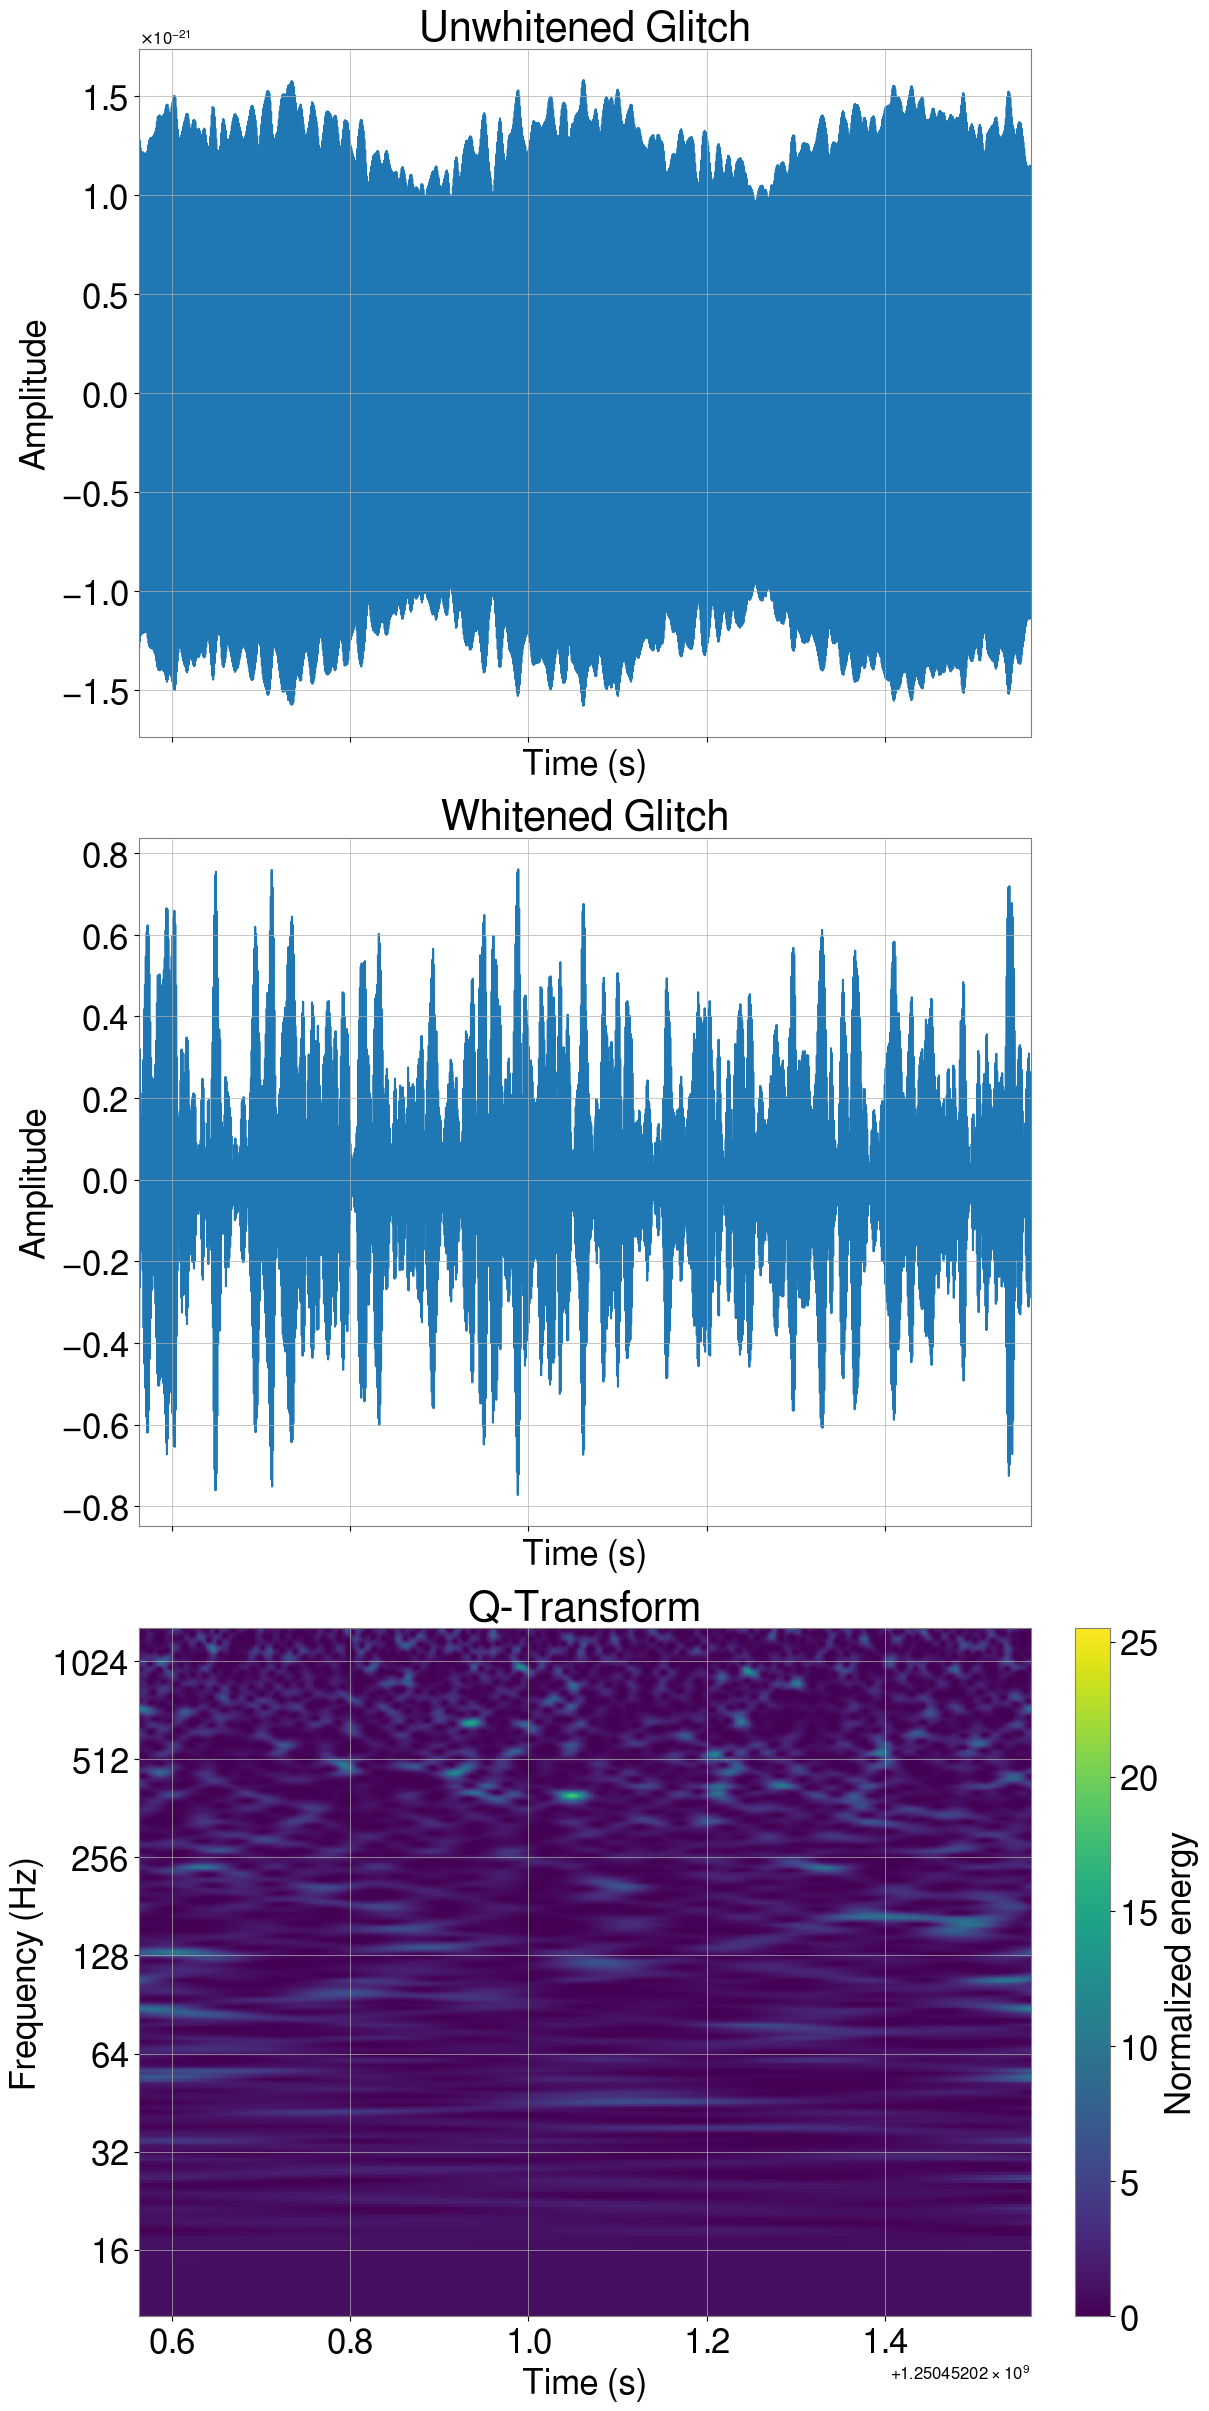

In [56]:
statistical_testing.display_sample_plots(combined_df[combined_df['label'] == 'Scattered_Light'].sample(1).iloc[0])

# Experimenting with the Fractal Dimension

The fractal dimension is another way for us to visualize and characterize our data. FD characterizes the self similarity of a set and provides a measure of complexity of the signal in terms of signal processing. Basically, it tells us how complex a shape is, which in this case would be the shape of the time series signal. If we were to use this in the context of time series signals, it would be as a **Variation over Time** telling us how complex the signal is. Glitches cause this FD value to change.

For this we use the VAR method. (Referenced from LIGO repositories)

In [44]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
# combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, observation_tw=5, n_samples=2000)

Input Length:  700


Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [45]:
combined_df.shape

(3593, 17)

In [46]:
# Tomte
example = combined_df.loc[combined_df['label'] == 'Tomte'].iloc[0]
example_ts = statistical_testing.get_sample_glitch_from_filepath(example["timeseries_file_location"], observation_tw=5)[1]

In [47]:
# Clean Signal
example2 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[1]

example_ts2 = TimeSeries.read(example2["timeseries_file_location"])
example_ts2 = example_ts2.whiten(4,2)
example_ts2 = example_ts2[int(4096):int(20480)]

asd = example_ts2.asd()

In [48]:
# Scattered Light
example3 = combined_df.loc[combined_df['label'] == 'Scattered_Light'].iloc[0]
example_ts3 = statistical_testing.get_sample_glitch_from_filepath(example3["timeseries_file_location"], observation_tw=5)[1]

In [49]:
example["timeseries_file_location"]

'./timeseries_data/sample_L1_1248235640.34_white10.h5'

In [50]:
example_ts.shape

(20480,)

In [51]:
np.arange(0, 4096//(2*64))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31])

In [52]:
import numba

### What's happening here (My understanding of it)

F_k contains all the fractional dimensions being calculated for the given TimeSeries signal given the decimate value.

To calculate F_k, the outer loop takes values from 1 to half the length of the signal times the deimate, while the inner loop goes from the value of the outer loop to the end of the signal minus the outer loop value. At each iteration of the inner loop a window  of size [k-l, k-l+1] goes along the signal and calculates the absolute value of the difference between the minimum and maximum amplitude values, the mean of which us the A_var values. With each outer iteration the size of this window increases gradually until it goes up to the whole length of the signal.

Second version of FD code (the correct implementation) 

In [53]:
@numba.njit("f4[:](f4[:,:], i8, i8)", parallel=True)
def faster_compute_fractals_var(fs, dec, step):
    FDs = np.empty(shape=fs.shape[0], dtype=np.float32)
    N = fs.shape[1]
    for ii in numba.prange(fs.shape[0]):
        f = fs[ii]
        k_n = np.arange(1, N//(2*dec), step, np.int64)
        n_max = len(k_n)
        V_i = np.empty(shape=(n_max), dtype=np.float32)

        ub = np.empty(shape=(N-2*k_n[0],2), dtype=np.float32) # current iteration
        for i in range(0, N-2*k_n[0]):
            ub[i,0] = np.max(f[i:i+2*k_n[0]+1])
            ub[i,1] = np.min(f[i:i+2*k_n[0]+1])
        V_i[0] = np.mean(ub[:,0]-ub[:,1])

        for n in range(1,n_max):
            d = k_n[n] - k_n[n-1]
            for i in range(0, N-2*k_n[n]):
                ub[i,0] = max(ub[i,0], ub[i+2*d,0])
                ub[i,1] = min(ub[i,1], ub[i+2*d,1])
            V_i[n] = np.mean(ub[:N-2*k_n[n],0]-ub[:N-2*k_n[n],1])

        X = np.log(k_n)
        X_m = X - np.mean(X)
        Y = np.log(V_i)
        Y_m = Y - np.mean(Y)
        FDs[ii] = 2 - np.sum((X_m)*(Y_m))/np.sum((X_m)**2)
    return FDs


In [54]:
def segmentize(data, seg_length, overlap):
    """
    Segment the data into overlapping segments.
    """

    data_strides = data.strides

    num_segs = int((data.shape[1] - overlap)/(seg_length - overlap))
    seg_shape = (data.shape[0], num_segs, seg_length)

    seg_strides = (data_strides[0], data_strides[1]*(seg_length - overlap), data_strides[1])

    segs = np.lib.stride_tricks.as_strided(data, shape=seg_shape, strides=seg_strides)

    return segs
    

In [55]:
# eg_ts2d_chunks = np.split(example_ts.value, 64)

In [56]:
# len(eg_ts2d_chunks)

In [57]:
# eg_fd1 = []
# for chunk in eg_ts2d_chunks:
#     eg_fd1.append(faster_compute_fractals_var(np.array(chunk.reshape(1,-1).astype(np.float32)), dec=8, step=2))

In [58]:
eg_ts2d = example_ts.value.reshape(1,-1).astype(np.float32)

In [59]:
eg_ts2d.shape

(1, 20480)

In [60]:
eg_ts2d_segmented = segmentize(eg_ts2d, 64, 32)

In [61]:
eg_ts2d_segmented.shape

(1, 639, 64)

In [62]:
points_per_seg = eg_ts2d_segmented.shape[1]
eg_ts2d_segmented = eg_ts2d_segmented.reshape(eg_ts2d_segmented.shape[0]*eg_ts2d_segmented.shape[1], eg_ts2d_segmented.shape[2])

In [63]:
eg_ts2d_segmented.shape

(639, 64)

In [64]:
eg_fd1 = faster_compute_fractals_var(eg_ts2d_segmented, dec=2, step=2)

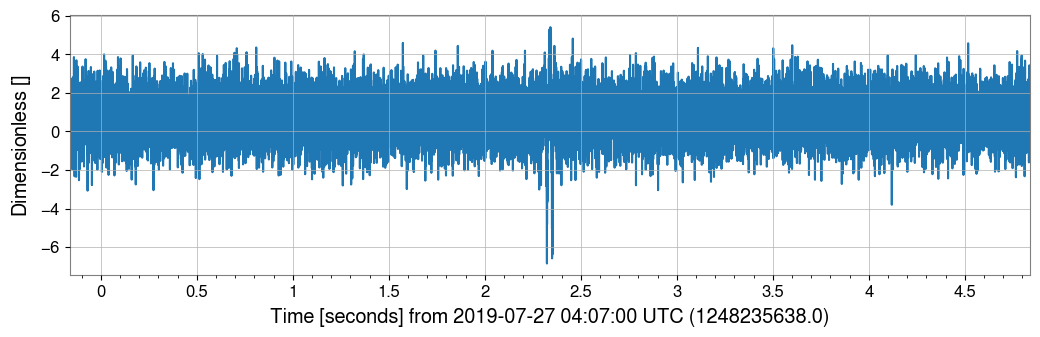

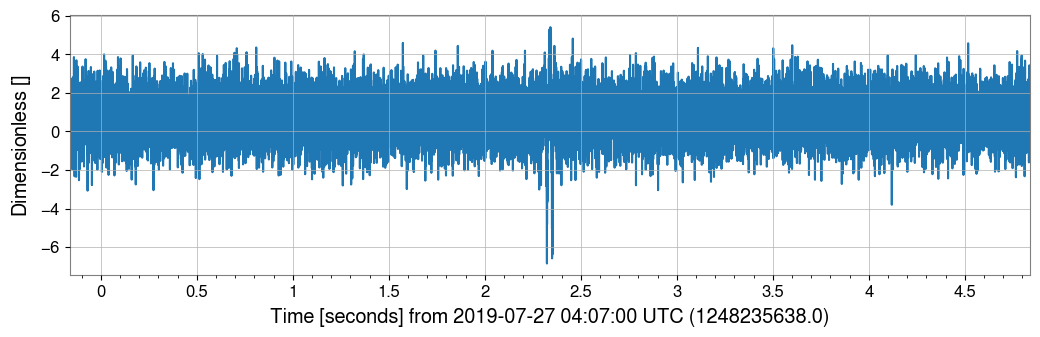

In [65]:
example_ts.plot()

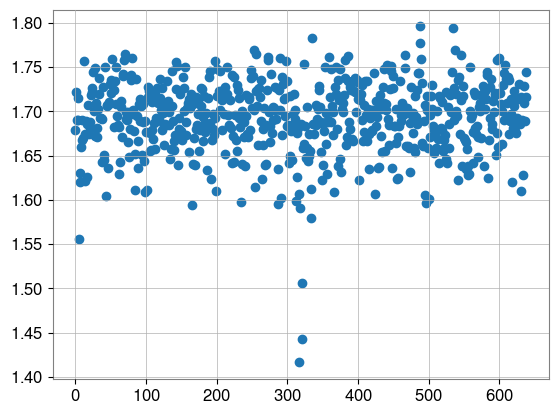

In [66]:
# Tomte
plt.plot(eg_fd1, 'o')

In [67]:
eg_ts2d2 = example_ts2.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented2 = segmentize(eg_ts2d2, 64, 32)
points_per_seg = eg_ts2d_segmented2.shape[1]
eg_ts2d_segmented2 = eg_ts2d_segmented2.reshape(eg_ts2d_segmented2.shape[0]*eg_ts2d_segmented2.shape[1], eg_ts2d_segmented2.shape[2])
eg_fd2 = faster_compute_fractals_var(eg_ts2d_segmented2, dec=2, step=2)

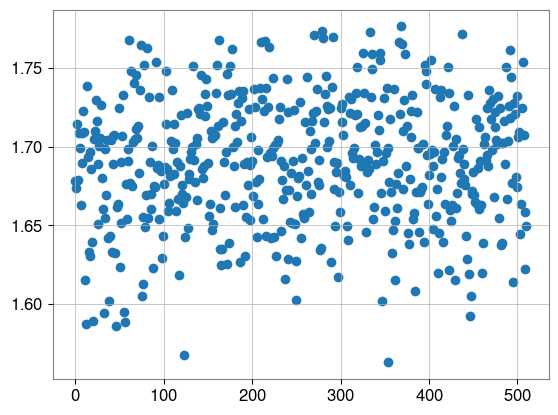

In [68]:
#Clean Signal
plt.plot(eg_fd2, 'o')

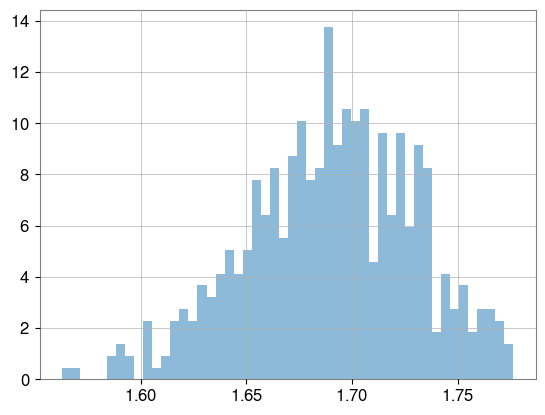

In [69]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.show()

In [70]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)

In [71]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented3 = segmentize(eg_ts2d3, 64, 32)
points_per_seg = eg_ts2d_segmented3.shape[1]
eg_ts2d_segmented3 = eg_ts2d_segmented3.reshape(eg_ts2d_segmented3.shape[0]*eg_ts2d_segmented3.shape[1], eg_ts2d_segmented3.shape[2])
eg_fd3 = faster_compute_fractals_var(eg_ts2d_segmented3, dec=2, step=2)

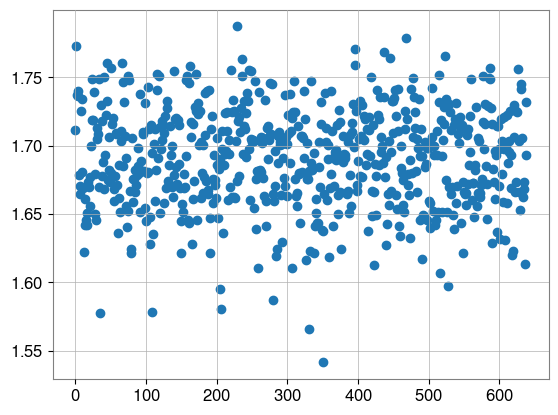

In [72]:
#Scattered Light
plt.plot(eg_fd3, 'o')

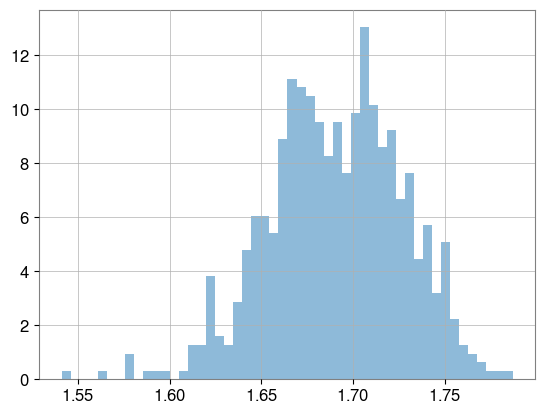

In [73]:
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.show()

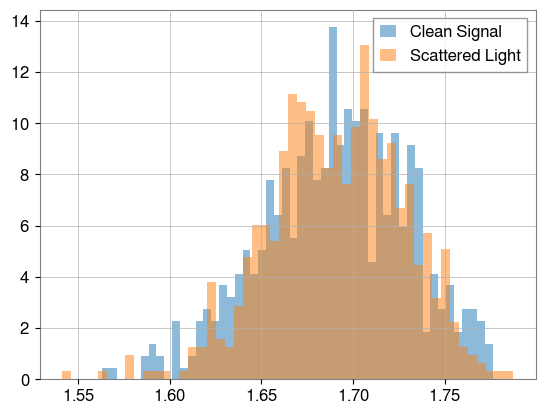

In [74]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Clean Signal', density=True)
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.legend()
plt.show()

In [75]:
example3

whitened_y                  [0.17144254946917892, -0.4730252684957443, -2....
t                           [1253141883.125 s, 1253141883.1252441 s, 12531...
timeseries_file_location    ./timeseries_data/sample_L1_1253141883.625_whi...
unwhitened_y                [-1.9957965453186446e-19, -1.9340591362930947e...
shapiro_statistic                                                     0.99939
shapiro_pvalue                                                        0.19322
ks_statistic                                                          0.01524
ks_pvalue                                                             0.29473
ad_statistic                                                          0.51970
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.06709
skew                                                            

In [76]:
example4 = combined_df.loc[combined_df['label'] == 'Extremely_Loud'].iloc[1]
example_ts4 = statistical_testing.get_sample_glitch_from_filepath(example4["timeseries_file_location"], observation_tw=5)[1]

In [77]:
eg_ts2d4 = example_ts4.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented4 = segmentize(eg_ts2d4, 64, 32)
points_per_seg = eg_ts2d_segmented4.shape[1]
eg_ts2d_segmented4 = eg_ts2d_segmented4.reshape(eg_ts2d_segmented4.shape[0]*eg_ts2d_segmented4.shape[1], eg_ts2d_segmented4.shape[2])
eg_fd4 = faster_compute_fractals_var(eg_ts2d_segmented4, dec=2, step=2)

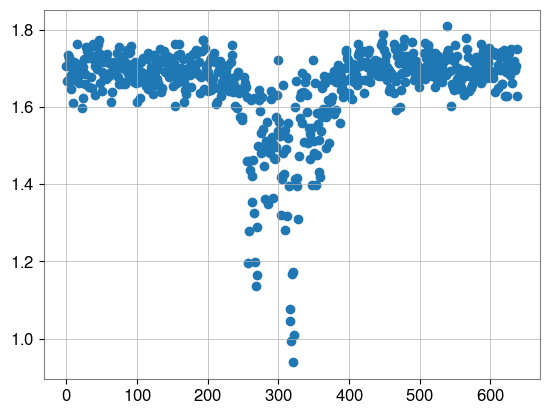

In [78]:
# Extremely Loud
plt.plot(eg_fd4, 'o')

In [79]:
# Clean Signal
example5 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[1]

example_ts5 = TimeSeries.read(example5["timeseries_file_location"])
example_ts5 = example_ts5.whiten(4,2)
example_ts5 = example_ts5[int(4096):int(20480)]

asd = example_ts5.asd()

In [80]:
eg_ts2d5 = example_ts2.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented5 = segmentize(eg_ts2d5, 64, 32)
points_per_seg = eg_ts2d_segmented5.shape[1]
eg_ts2d_segmented5 = eg_ts2d_segmented5.reshape(eg_ts2d_segmented5.shape[0]*eg_ts2d_segmented5.shape[1], eg_ts2d_segmented5.shape[2])
eg_fd5 = faster_compute_fractals_var(eg_ts2d_segmented5, dec=2, step=2)

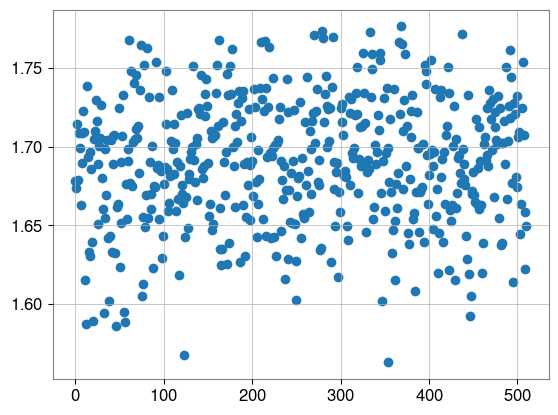

In [81]:
plt.plot(eg_fd5, 'o')

In [82]:
# Blip example
example6 = combined_df.loc[combined_df['label'] == 'Blip'].iloc[5]
example_ts6 = statistical_testing.get_sample_glitch_from_filepath(example6["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d6 = example_ts6.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented6 = segmentize(eg_ts2d6, 64, 32)
points_per_seg6 = eg_ts2d_segmented6.shape[1]
eg_ts2d_segmented6 = eg_ts2d_segmented6.reshape(eg_ts2d_segmented6.shape[0]*eg_ts2d_segmented6.shape[1], eg_ts2d_segmented6.shape[2])
eg_fd6 = faster_compute_fractals_var(eg_ts2d_segmented6, dec=2, step=2)

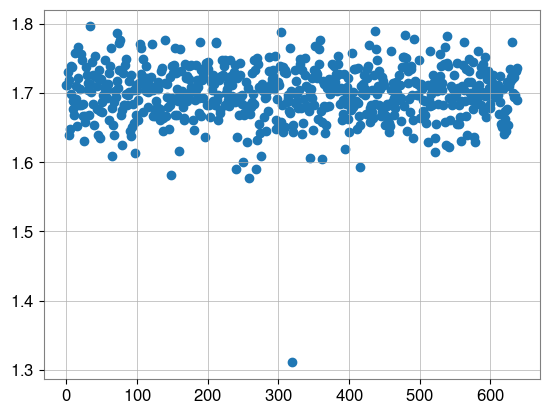

In [83]:
plt.plot(eg_fd6, 'o')

In [84]:
# 1080Lines example
example7 = combined_df.loc[combined_df['label'] == '1080Lines'].iloc[1]
example_ts7 = statistical_testing.get_sample_glitch_from_filepath(example7["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d7 = example_ts7.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented7 = segmentize(eg_ts2d7, 64, 32)
points_per_seg7 = eg_ts2d_segmented7.shape[1]
eg_ts2d_segmented7 = eg_ts2d_segmented7.reshape(eg_ts2d_segmented7.shape[0]*eg_ts2d_segmented7.shape[1], eg_ts2d_segmented7.shape[2])
eg_fd7 = faster_compute_fractals_var(eg_ts2d_segmented7, dec=2, step=2)

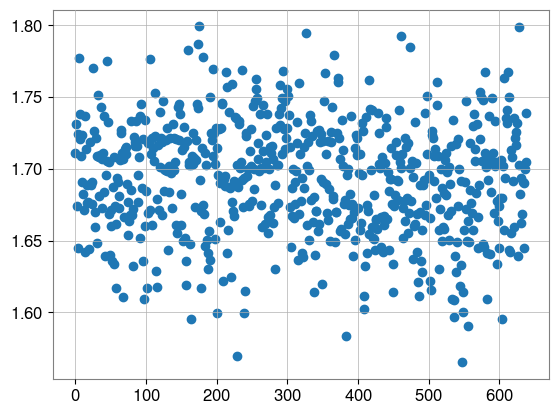

In [85]:
plt.plot(eg_fd7, 'o')

In [86]:
# Chirp example
example8 = combined_df.loc[combined_df['label'] == 'Chirp'].iloc[1]
example_ts8 = statistical_testing.get_sample_glitch_from_filepath(example8["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d8 = example_ts8.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented8 = segmentize(eg_ts2d8, 64, 32)
points_per_seg8 = eg_ts2d_segmented8.shape[1]
eg_ts2d_segmented8 = eg_ts2d_segmented8.reshape(eg_ts2d_segmented8.shape[0]*eg_ts2d_segmented8.shape[1], eg_ts2d_segmented8.shape[2])
eg_fd8 = faster_compute_fractals_var(eg_ts2d_segmented8, dec=2, step=2)

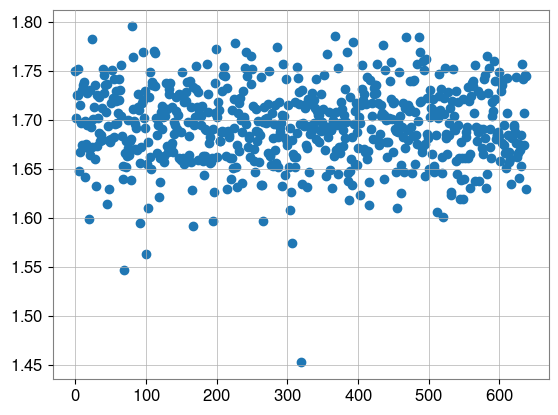

In [87]:
plt.plot(eg_fd8, 'o')

In [88]:
# Koi_Fish example
example9 = combined_df.loc[combined_df['label'] == 'Koi_Fish'].iloc[1]
example_ts9 = statistical_testing.get_sample_glitch_from_filepath(example9["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d9 = example_ts9.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented9 = segmentize(eg_ts2d9, 64, 32)
points_per_seg9 = eg_ts2d_segmented9.shape[1]
eg_ts2d_segmented9 = eg_ts2d_segmented9.reshape(eg_ts2d_segmented9.shape[0]*eg_ts2d_segmented9.shape[1], eg_ts2d_segmented9.shape[2])
eg_fd9 = faster_compute_fractals_var(eg_ts2d_segmented9, dec=2, step=2)

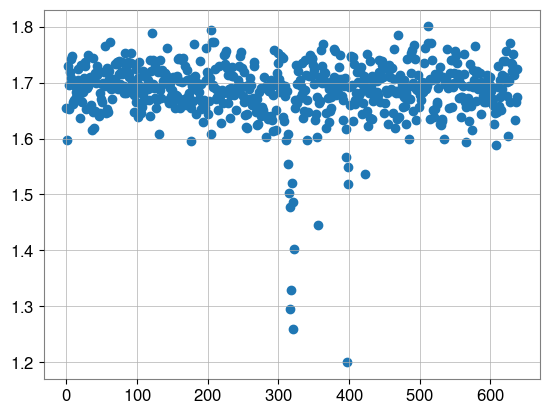

In [89]:
plt.plot(eg_fd9, 'o')

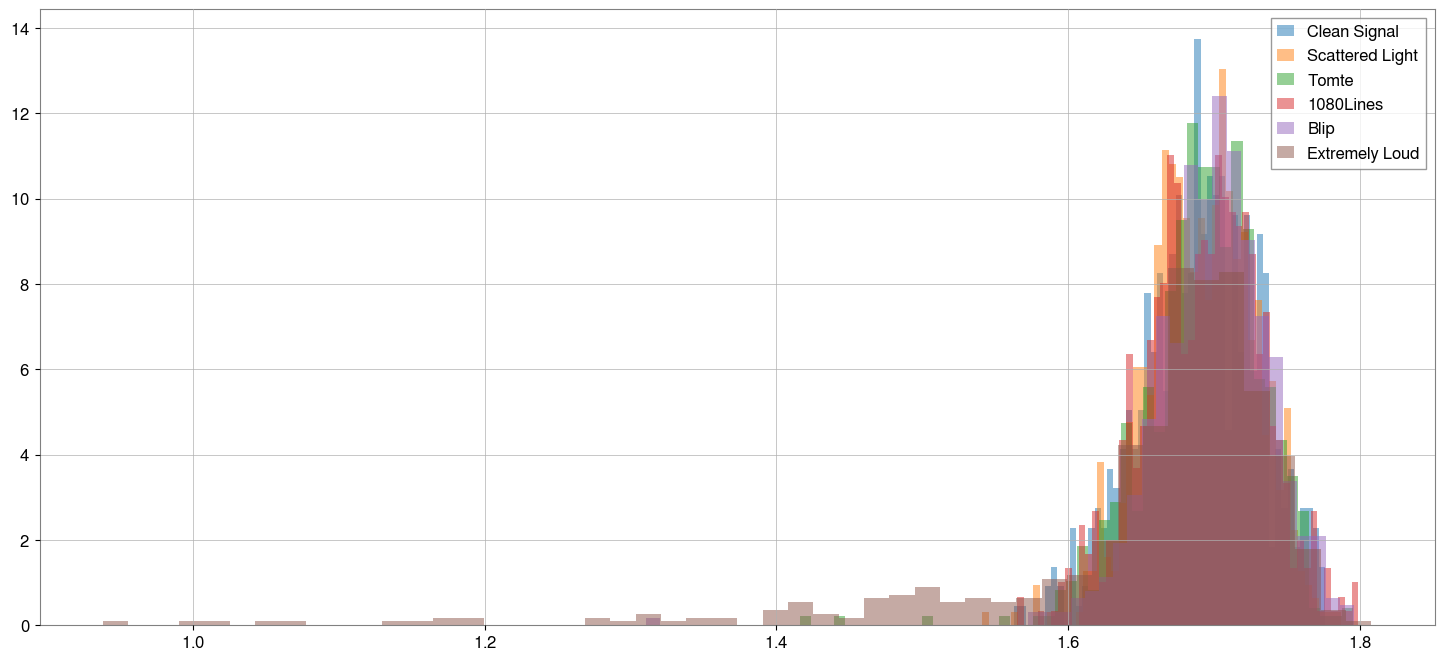

In [90]:
plt.figure(figsize=(18, 8))
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Clean Signal', density=True)
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.hist(eg_fd1, bins=50, alpha=0.5, label='Tomte', density=True)
plt.hist(eg_fd7, bins=50, alpha=0.5, label='1080Lines', density=True)
plt.hist(eg_fd6, bins=50, alpha=0.5, label='Blip', density=True)
plt.hist(eg_fd4, bins=50, alpha=0.5, label='Extremely Loud', density=True)
plt.legend()
plt.show()

In [91]:
for i in range(6):
    example_clean = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[i]
    example_clean_ts = TimeSeries.read(example_clean["timeseries_file_location"])
    example_clean_ts = example_clean_ts.whiten(4,2)
    example_clean_ts = example_clean_ts[int(4096*(i+1)):int(4096*(i+2))]
    example_clean_ts = example_clean_ts.value.reshape(1,-1).astype(np.float32)
    example_clean_ts_segmented = segmentize(example_clean_ts, 64, 32)
    points_per_seg = example_clean_ts_segmented.shape[1]
    example_clean_ts_segmented = example_clean_ts_segmented.reshape(example_clean_ts_segmented.shape[0]*example_clean_ts_segmented.shape[1], example_clean_ts_segmented.shape[2])

    example_tomte = combined_df.loc[combined_df['label'] == 'Tomte'].iloc[i]
    example_tomte_ts = statistical_testing.get_sample_glitch_from_filepath(example_tomte["timeseries_file_location"], observation_tw=1)[1]
    example_tomte_ts = example_tomte_ts.value.reshape(1,-1).astype(np.float32)
    example_tomte_ts_segmented = segmentize(example_tomte_ts, 64, 32)
    points_per_seg = example_tomte_ts_segmented.shape[1]
    example_tomte_ts_segmented = example_tomte_ts_segmented.reshape(example_tomte_ts_segmented.shape[0]*example_tomte_ts_segmented.shape[1], example_tomte_ts_segmented.shape[2])

    example_blip = combined_df.loc[combined_df['label'] == 'Blip'].iloc[i]
    example_blip_ts = statistical_testing.get_sample_glitch_from_filepath(example_blip["timeseries_file_location"], observation_tw=1)[1]
    example_blip_ts = example_blip_ts.value.reshape(1,-1).astype(np.float32)
    example_blip_ts_segmented = segmentize(example_blip_ts, 64, 32)
    points_per_seg = example_blip_ts_segmented.shape[1]
    example_blip_ts_segmented = example_blip_ts_segmented.reshape(example_blip_ts_segmented.shape[0]*example_blip_ts_segmented.shape[1], example_blip_ts_segmented.shape[2])

    example_scattered = combined_df.loc[combined_df['label'] == 'Scattered_Light'].iloc[i]
    example_scattered_ts = statistical_testing.get_sample_glitch_from_filepath(example_scattered["timeseries_file_location"], observation_tw=1)[1]
    example_scattered_ts = example_scattered_ts.value.reshape(1,-1).astype(np.float32)
    example_scattered_ts_segmented = segmentize(example_scattered_ts, 64, 32)
    points_per_seg = example_scattered_ts_segmented.shape[1]
    example_scattered_ts_segmented = example_scattered_ts_segmented.reshape(example_scattered_ts_segmented.shape[0]*example_scattered_ts_segmented.shape[1], example_scattered_ts_segmented.shape[2])
    
    if i == 0:
        clean_fd = faster_compute_fractals_var(example_clean_ts_segmented, dec=2, step=2)/6
        tomte_fd = faster_compute_fractals_var(example_tomte_ts_segmented, dec=2, step=2)/6
        blip_fd = faster_compute_fractals_var(example_blip_ts_segmented, dec=2, step=2)/6
        scattered_fd = faster_compute_fractals_var(example_scattered_ts_segmented, dec=2, step=2)/6
    else:
        clean_fd += faster_compute_fractals_var(example_clean_ts_segmented, dec=2, step=2)/6
        tomte_fd += faster_compute_fractals_var(example_tomte_ts_segmented, dec=2, step=2)/6
        blip_fd += faster_compute_fractals_var(example_blip_ts_segmented, dec=2, step=2)/6
        scattered_fd += faster_compute_fractals_var(example_scattered_ts_segmented, dec=2, step=2)/6
        

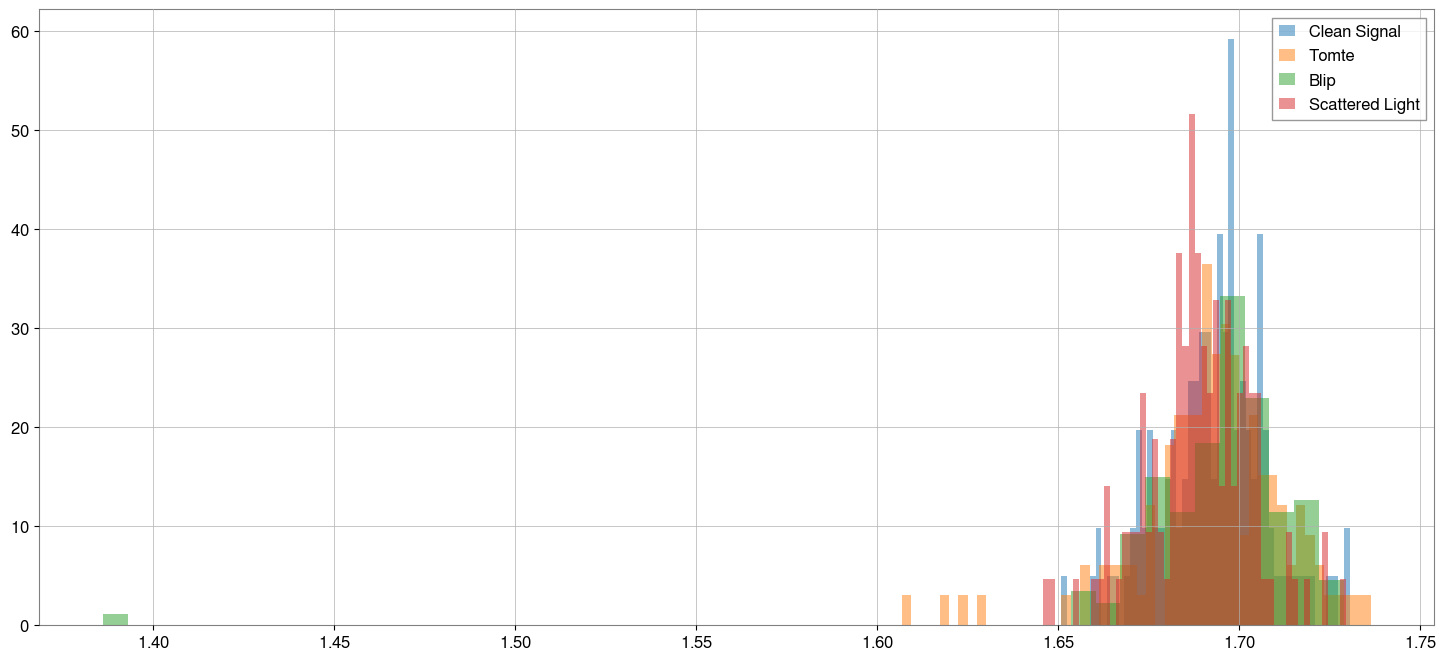

In [92]:
plt.figure(figsize=(18, 8))
plt.hist(clean_fd, bins=50, alpha=0.5, label='Clean Signal', density=True)
plt.hist(tomte_fd, bins=50, alpha=0.5, label='Tomte', density=True)
plt.hist(blip_fd, bins=50, alpha=0.5, label='Blip', density=True)
plt.hist(scattered_fd, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.legend()
plt.show()

### Studying the FFTs of the signals

In [93]:
from scipy import signal

eg_fft = example_ts.fft()
eg_fft2 = example_ts2.fft()
eg_fft3 = example_ts3.fft()

f1, t1, Zxx1 = signal.stft(example_ts, fs=4096, nperseg=32, noverlap=16)
f2, t2, Zxx2 = signal.stft(example_ts2, fs=4096, nperseg=32, noverlap=16)
f3, t3, Zxx3 = signal.stft(example_ts3, fs=4096, nperseg=32, noverlap=16)

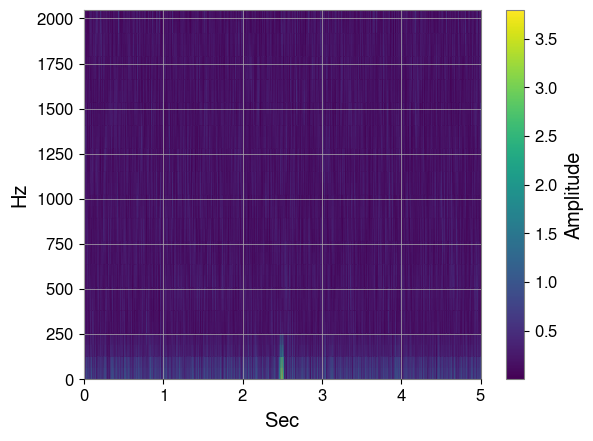

In [94]:
# Tomte
plt.pcolormesh(t1, f1, np.abs(Zxx1), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

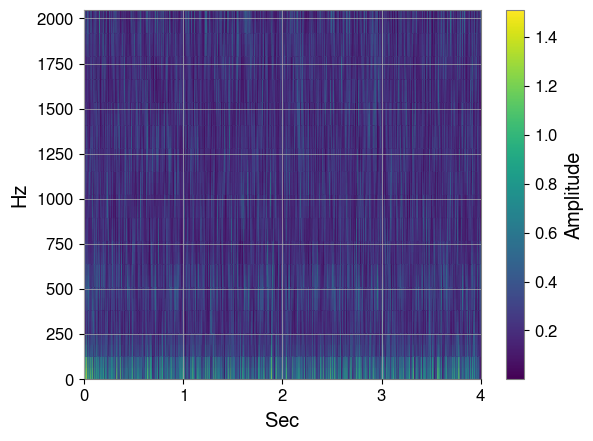

In [95]:
# Clean Signal
plt.pcolormesh(t2, f2, np.abs(Zxx2), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

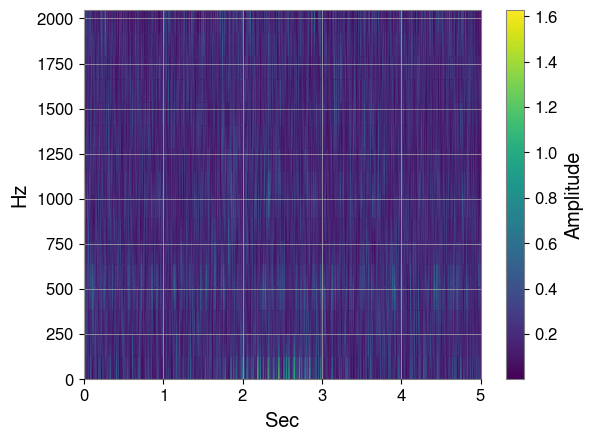

In [96]:
# Scattered Light
plt.pcolormesh(t3, f3, np.abs(Zxx3), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

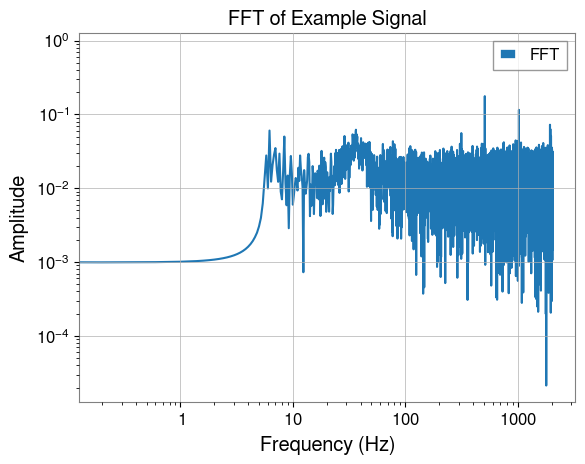

In [97]:
# Tomte
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

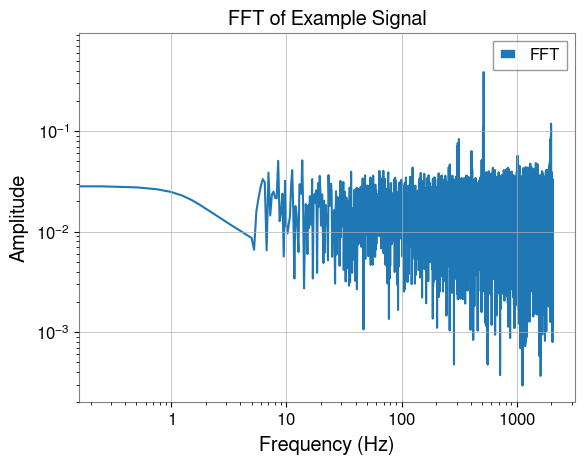

In [98]:
# Clean Data
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

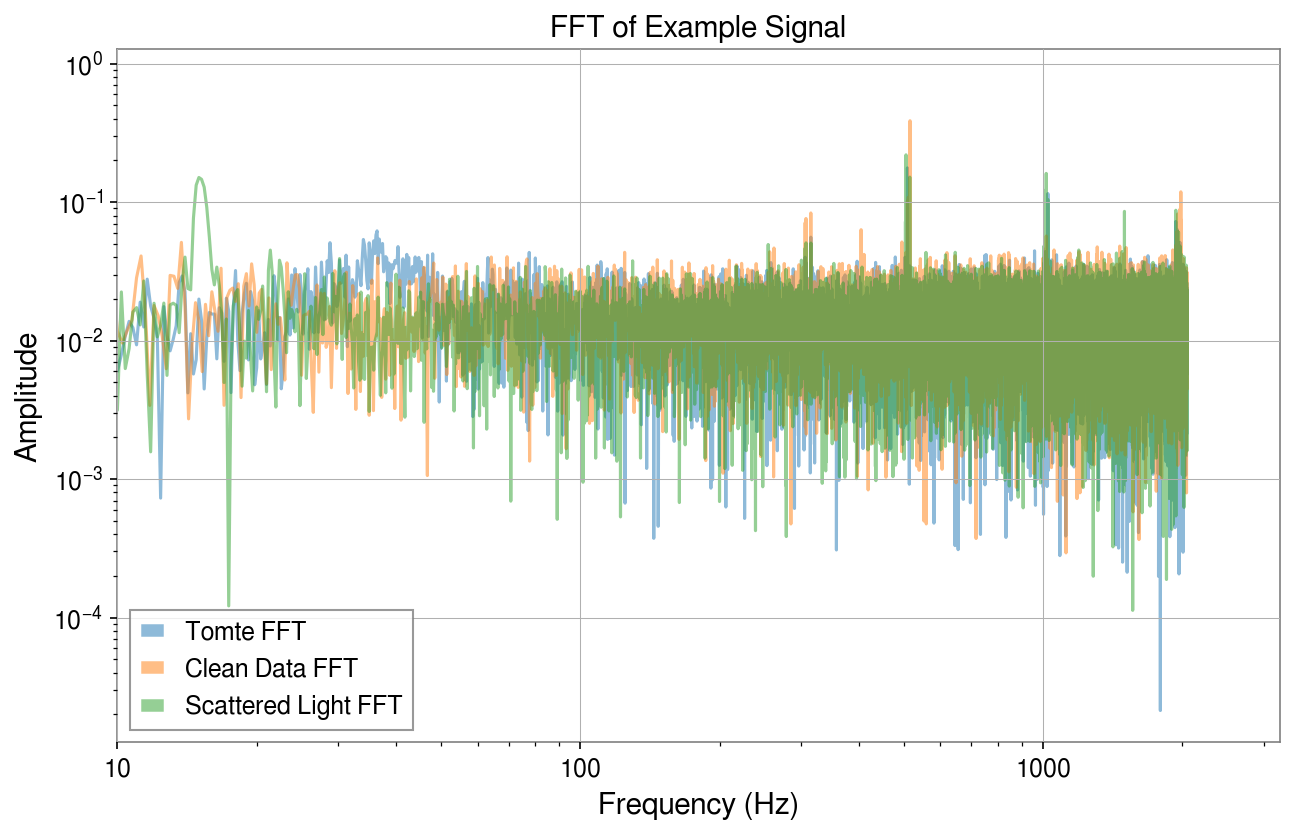

In [99]:
# Scattered Light
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="Tomte FFT", alpha=0.5)
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="Clean Data FFT", alpha=0.5)
plt.plot(eg_fft3.frequencies, np.abs(eg_fft3.value), label="Scattered Light FFT", alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

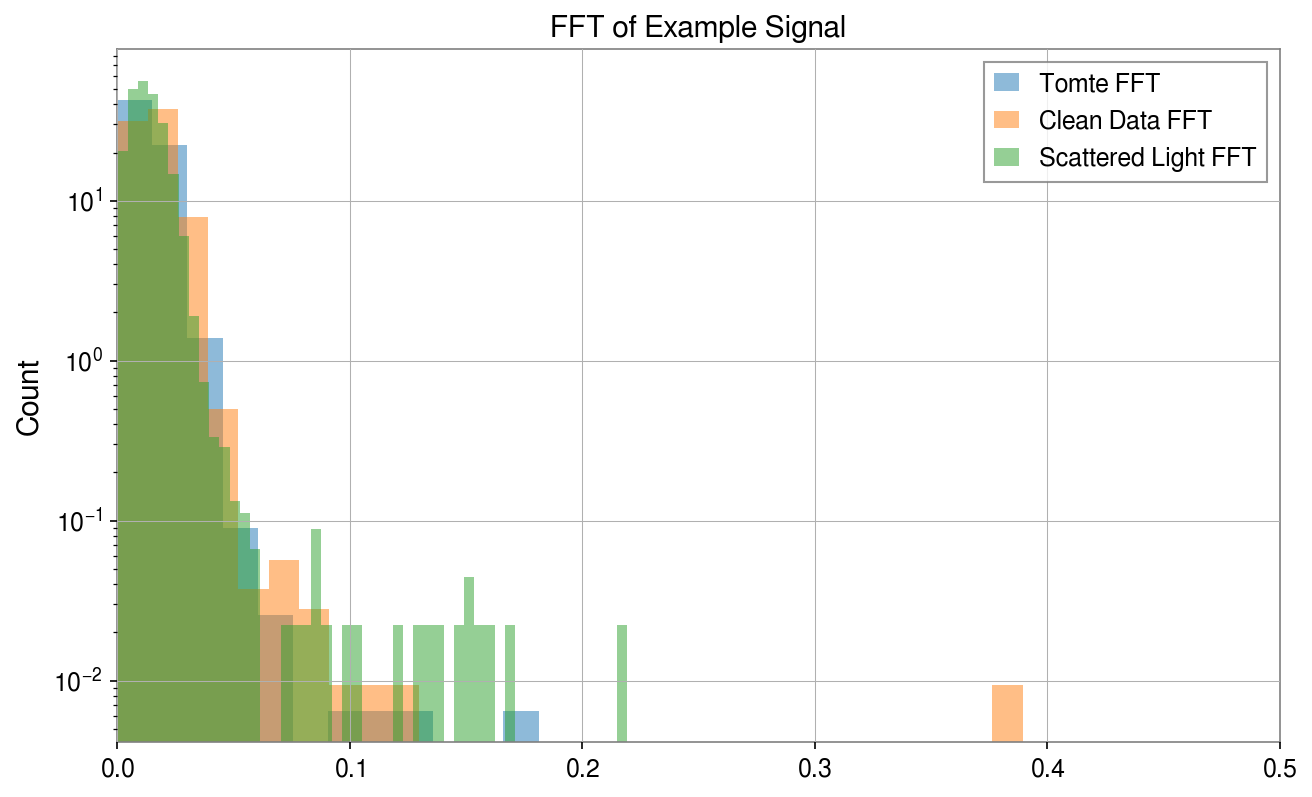

In [100]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(np.abs(eg_fft.value), label="Tomte FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft2.value), label="Clean Data FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft3.value), label="Scattered Light FFT", bins=50, density=True, alpha=0.5)
plt.yscale('log')
plt.xlim(0,0.5)
plt.ylabel("Count")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

In [101]:
example

whitened_y                  [1.2005277799111047, 0.2652399595154659, 2.999...
t                           [1248235639.8398438 s, 1248235639.840088 s, 12...
timeseries_file_location    ./timeseries_data/sample_L1_1248235640.34_whit...
unwhitened_y                [-1.912832129443173e-19, -1.779985834789845e-1...
shapiro_statistic                                                     0.98371
shapiro_pvalue                                                        0.00000
ks_statistic                                                          0.02218
ks_pvalue                                                             0.03501
ad_statistic                                                          5.07267
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              5.02047
skew                                                            

In [102]:
example2

whitened_y                  [-1.0445034733494019, -0.03988255036441557, -0...
t                           [1239082671.3659668 s, 1239082671.366211 s, 12...
timeseries_file_location    ./timeseries_data/sample_L1_cleanseg_123908266...
unwhitened_y                [5.438241096999612e-20, 4.962839640503188e-20,...
shapiro_statistic                                                     0.99916
shapiro_pvalue                                                        0.04550
ks_statistic                                                          0.00945
ks_pvalue                                                             0.85394
ad_statistic                                                          0.44434
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.12244
skew                                                            

In [103]:
example3

whitened_y                  [0.17144254946917892, -0.4730252684957443, -2....
t                           [1253141883.125 s, 1253141883.1252441 s, 12531...
timeseries_file_location    ./timeseries_data/sample_L1_1253141883.625_whi...
unwhitened_y                [-1.9957965453186446e-19, -1.9340591362930947e...
shapiro_statistic                                                     0.99939
shapiro_pvalue                                                        0.19322
ks_statistic                                                          0.01524
ks_pvalue                                                             0.29473
ad_statistic                                                          0.51970
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.06709
skew                                                            

In [104]:
eg_q_transform, eg_time = statistical_testing.calculate_q_transform(example_ts)
eg_q_transform2, eg_time2 = statistical_testing.calculate_q_transform(example_ts2)
eg_q_transform3, eg_time3 = statistical_testing.calculate_q_transform(example_ts3)

print(eg_time,eg_time2,eg_time3)

0.26332879066467285 0.29126882553100586 0.31839466094970703


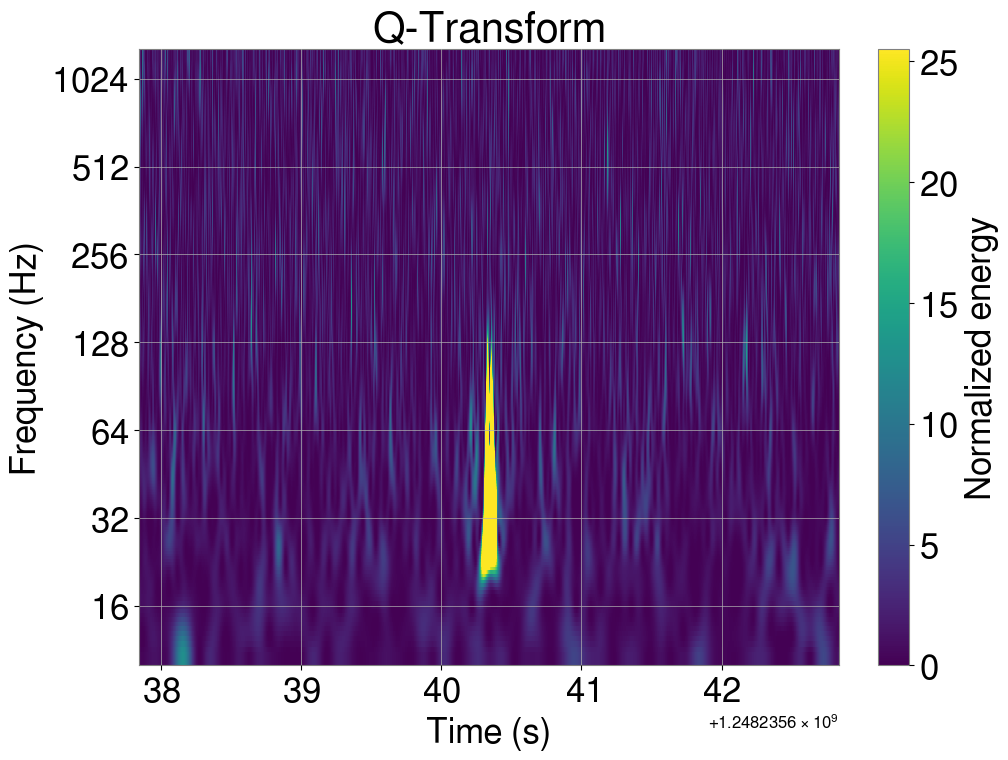

In [105]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

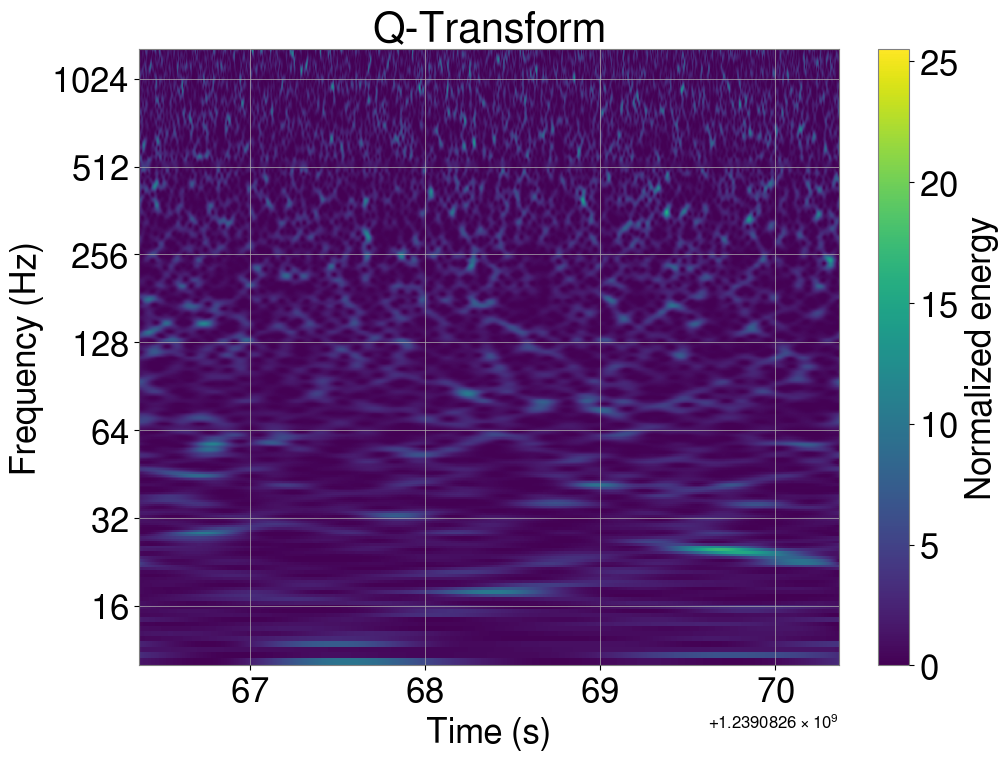

In [106]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform2)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

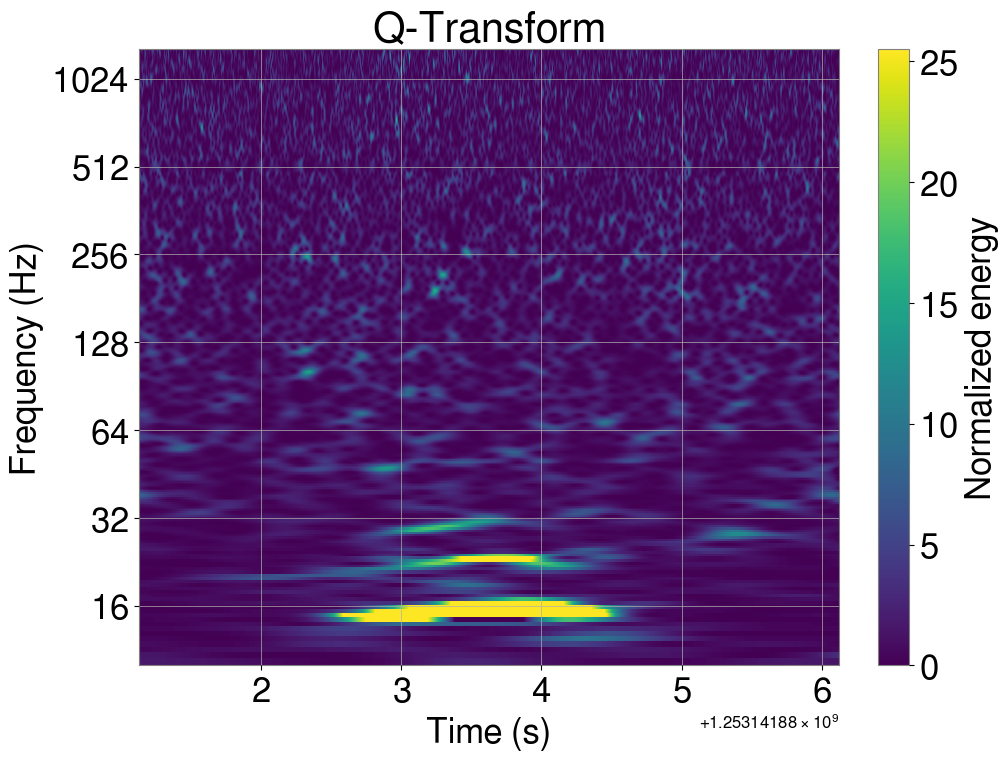

In [107]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform3)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

# Plots for the report

1. Gaussian Distribution

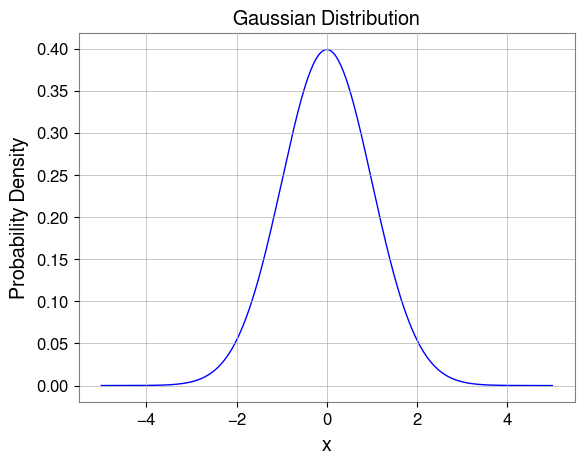

In [108]:
x = np.linspace(-5, 5, 1000)

mean = 0
stddev = 1

pdf = stats.norm.pdf(x, mean, stddev)

plt.plot(x, pdf, color='blue', linewidth=1)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution')
plt.grid(True)
plt.savefig("./outputs/gaussian_distribution.pdf", dpi=100)

2. Speed comparison for generating Q-transforms for different TimeSeries lengths

In [109]:
from gwosc.datasets import event_gps

gw150914_gpstime = event_gps('GW150914')

window_sizes = [4, 6, 8, 10, 12, 14, 16, 18, 20]

q_transform_times = []

# Loading TimeSeries data for GW150914

for window_size in window_sizes:
    gw_ts = TimeSeries.fetch_open_data('L1', gw150914_gpstime - window_size, gw150914_gpstime + window_size)
    gw_ts = gw_ts[int(4096):-int(4096)]
    gw_ts = gw_ts.whiten(4, 2)
    _, time = statistical_testing.calculate_q_transform(gw_ts)
    q_transform_times.append(time)

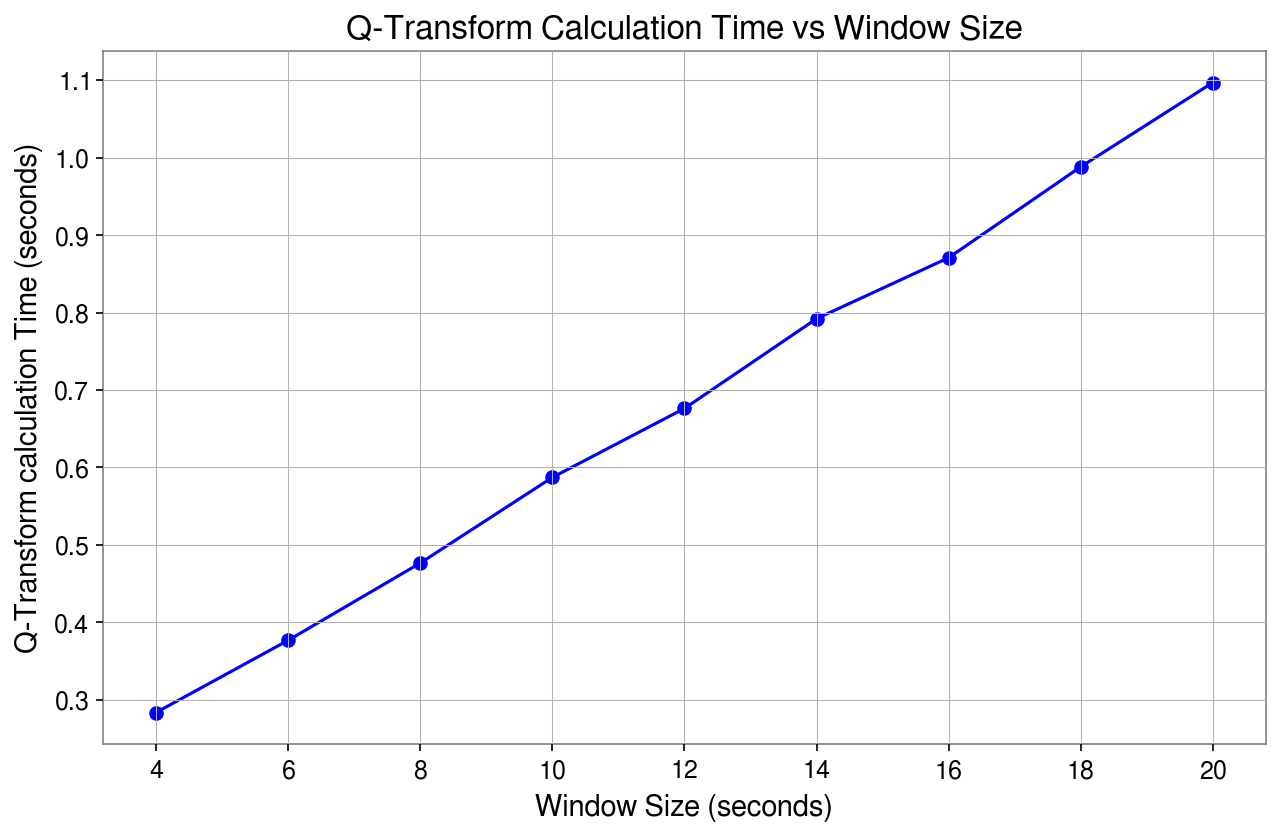

In [110]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(window_sizes, q_transform_times, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Window Size (seconds)', fontsize=14)
ax.set_ylabel('Q-Transform calculation Time (seconds)', fontsize=14)
ax.set_title('Q-Transform Calculation Time vs Window Size', fontsize=16)
ax.grid(True)
plt.xticks(window_sizes)
plt.savefig("./outputs/q_transform_time_vs_window_size.pdf", dpi=100)

3. Speed comparison of generating Q-transforms at a constant sample length but increasing number of samples 

In [111]:
glitch_sample_df = combined_df.loc[combined_df['label'] != 'clean_signal']


sample_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

q_transform_times = []

for sample_count in sample_counts:
    time = 0
    sample_df = glitch_sample_df.sample(sample_count)
    for index, row in sample_df.iterrows():
        ts = TimeSeries.read(row["timeseries_file_location"])
        ts = ts.whiten(4, 2)
        ts = ts[int(4096):-int(4096)]
        _, t = statistical_testing.calculate_q_transform(ts)
        time += t
    q_transform_times.append(time)

# example_ts3 = statistical_testing.get_sample_glitch_from_filepath(example3["timeseries_file_location"], observation_tw=5)[1]

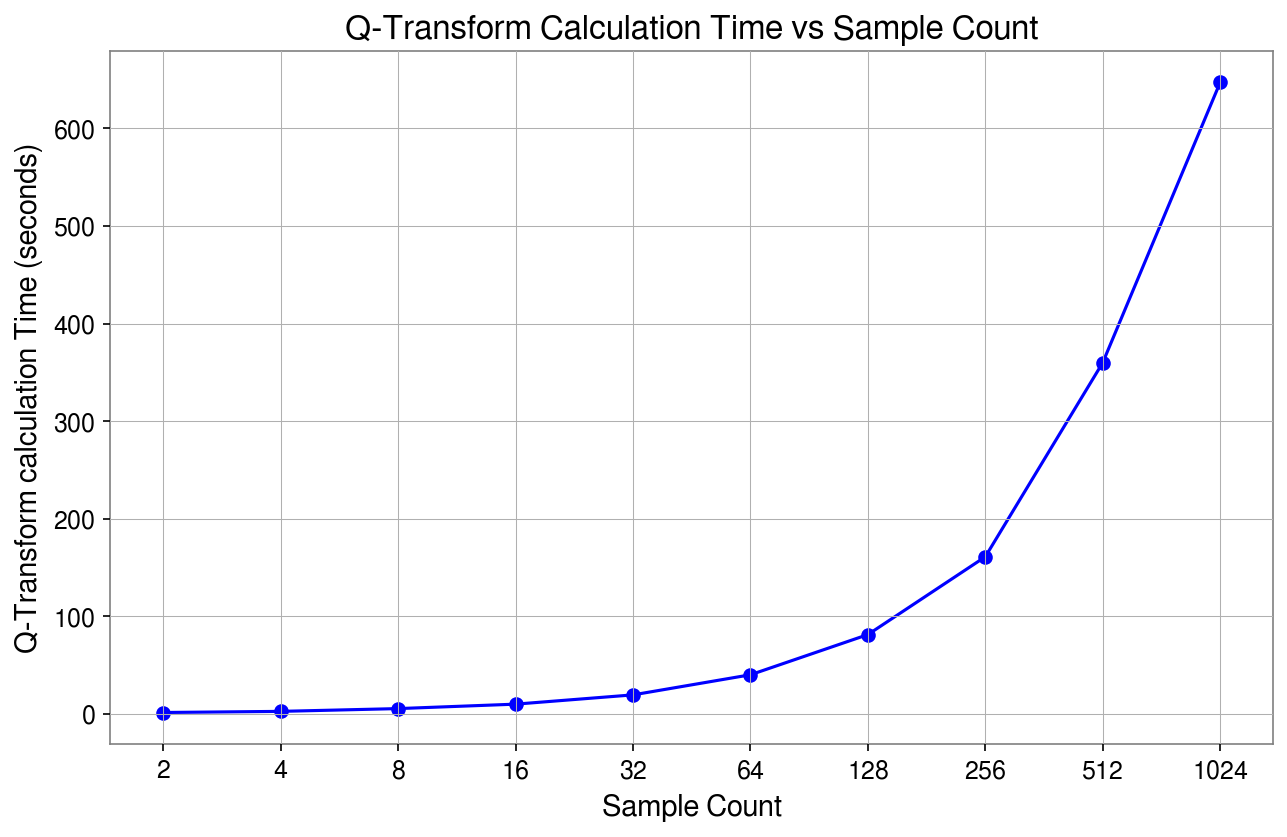

In [112]:
from matplotlib.ticker import LogLocator

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(sample_counts, q_transform_times, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Sample Count', fontsize=14)
ax.set_ylabel('Q-Transform calculation Time (seconds)', fontsize=14)
ax.set_title('Q-Transform Calculation Time vs Sample Count', fontsize=16)
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_xticks(sample_counts)
plt.savefig("./outputs/q_transform_time_vs_sample_count.pdf", dpi=100)

4. CDF vs ECDF for Kolmogorov-Smirnov Test

In [24]:
np.random.seed(42)  # For reproducibility
eg = combined_df.sample(1).iloc[0]

In [25]:
eg

whitened_y                  [0.4968656487621922, 0.8993886940788105, -2.54...
t                           [1240848778.5979004 s, 1240848778.5981445 s, 1...
timeseries_file_location    ./timeseries_data/sample_L1_1240848779.098_whi...
unwhitened_y                [-2.05152919443027e-19, -2.2642417222478256e-1...
shapiro_statistic                                                     0.99769
shapiro_pvalue                                                        0.00001
ks_statistic                                                          0.01657
ks_pvalue                                                             0.20853
ad_statistic                                                          1.39554
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.50857
skew                                                            

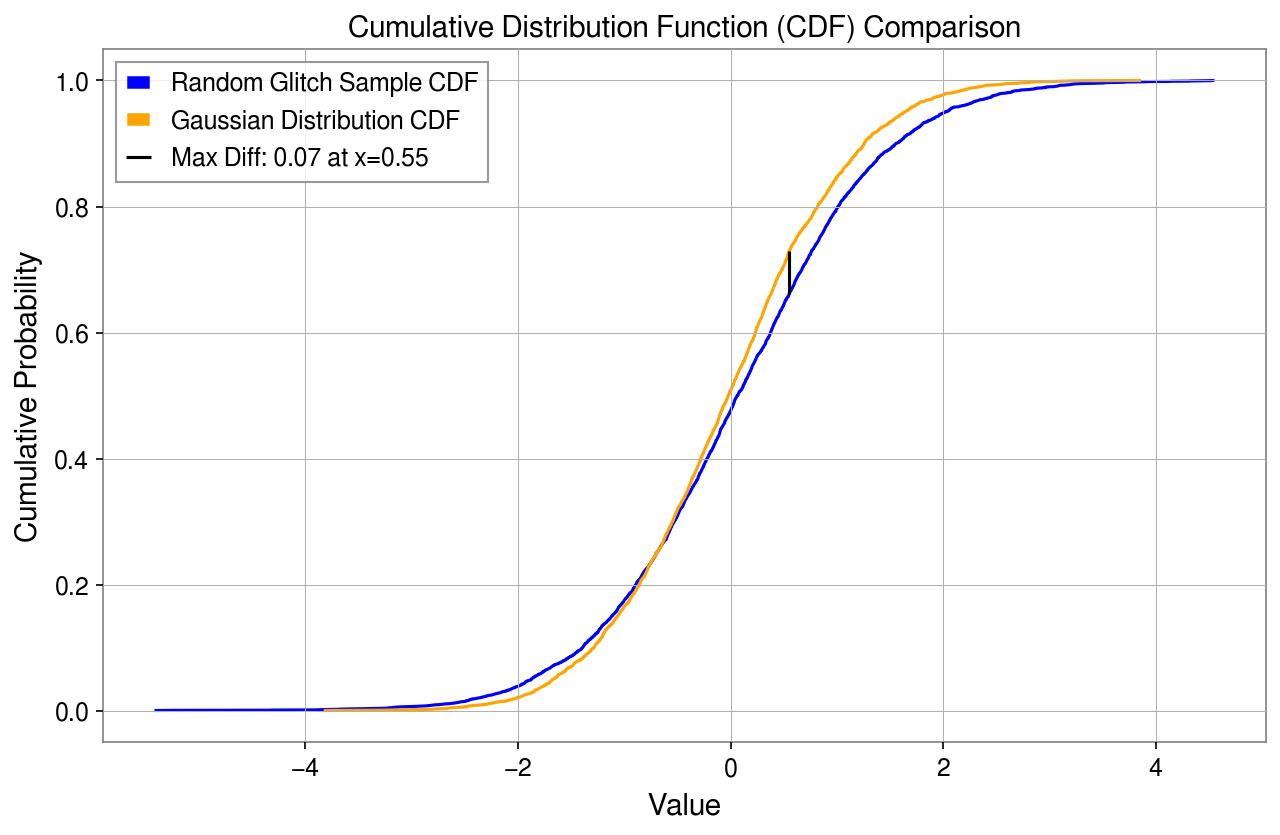

In [139]:
# Plot the CDF of glitch sample against a Gaussian Distribution
normal_dist = np.random.normal(loc=0, scale=1, size=4096)

x1 = np.sort(eg['whitened_y'])
x2 = np.sort(normal_dist)
y1 = np.arange(1, len(x1) + 1) / len(x1)
y2 = np.arange(1, len(x2) + 1) / len(x2)

all_x_values = np.sort(np.unique(np.concatenate((x1, x2))))

interp_y1 = np.interp(all_x_values, x1, y1)
interp_y2 = np.interp(all_x_values, x2, y2)

# Calculate the absolute differences
differences = np.abs(interp_y1 - interp_y2)

max_diff = np.max(differences)
max_diff_index = np.argmax(differences)
max_diff_x = all_x_values[max_diff_index]

fig = plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x1, y1, label='Random Glitch Sample CDF', color='blue')
plt.plot(x2, y2, label='Gaussian Distribution CDF', color='orange')
# Mark the  Maximum vertical difference between the two CDFs
plt.vlines(max_diff_x, min(interp_y1[max_diff_index], interp_y2[max_diff_index]), max(interp_y1[max_diff_index], interp_y2[max_diff_index]), color='black', linestyle='-', label=f'Max Diff: {max_diff:.2f} at x={max_diff_x:.2f}')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF) Comparison')
plt.legend()
plt.grid(True)
plt.savefig("./outputs/cdf_comparison_glitch_gaussian.pdf", dpi=100)